## 제주 빅데이터 경진대회
#### 이민혁
### Problem : 2020.04, 2020.07 기간 내 지역, 업종 별 월간 총 사용 금액 예측 
- 2019.01 ~ 2020.03 기간 내 카드 데이터, 201901-202003.csv (2.07 GB)
- 2020.04 기간 내 카드 데이터 (7/28 공개), 202004.csv (116 MB)
- 제출 양식, submission.csv (64 KB)


### 가장 최근에 나온 CatBoostRegression 사용

## 1. 라이브러리, 데이터 불러오기

In [264]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [306]:
data = pd.read_csv('201901-202003.csv')

In [307]:
data

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM  \
0           201901           강원         강릉시  건강보조식품 소매업          강원   
1           201901           강원         강릉시  건강보조식품 소매업          강원   
2           201901           강원         강릉시  건강보조식품 소매업          강원   
3           201901           강원         강릉시  건강보조식품 소매업          강원   
4           201901           강원         강릉시  건강보조식품 소매업          강원   
...            ...          ...         ...         ...         ...   
24697787    202003           충북         충주시    휴양콘도 운영업          충북   
24697788    202003           충북         충주시    휴양콘도 운영업          충북   
24697789    202003           충북         충주시    휴양콘도 운영업          충북   
24697790    202003           충북         충주시    휴양콘도 운영업          충북   
24697791    202003           충북         충주시    휴양콘도 운영업          충북   

         HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0               강릉시  20s            1    1          4   311200    4  
1               강릉시  30s            1    2          7  1374500    8  
2               강릉시  30s            2    2          6   818700    6  
3               강릉시  40s            1    3          4  1717000    5  
4               강릉시  40s            1    4          3  1047300    3  
...             ...  ...          ...  ...        ...      ...  ...  
24697787        충주시  30s            1    2          3    43300    4  
24697788        충주시  40s            1    3          3    35000    3  
24697789        충주시  50s            1    4          4   188000    6  
24697790        충주시  50s            2    4          4    99000    6  
24697791        충주시  60s            1    5          3   194000    3  

[24697792 rows x 12 columns]

**데이터 설명**

REG__YYMM = 년월

CARD_SIDO_NM = 카드이용지역_시도 (가맹점 주소 기준)

CARD_CCG_NM = 카드이용지역_시군구 (가맹점 주소 기준)

STD_CLSS_NM = 업종명

HOM_SIDO_NM = 거주지역_시도 (고객 집주소 기준)

HOM_CCG_NM = 거주지역_시군구 (고객 집주소 기준)

AGE = 연령대

SEX_CTGO_CD = 성별 (1: 남성, 2: 여성)

FLC = 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

CSTMR_CNT = 이용고객수 (명)

AMT = 이용금액 (원)

CNT = 이용건수 (건)

## 2. EDA

#### 1) 결측값 확인

In [308]:
data.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

시군구 지역의 결측 값들이 존재한다.

In [309]:
data[data['HOM_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM   STD_CLSS_NM HOM_SIDO_NM  \
420         201901           강원         강릉시   과실 및 채소 소매업          세종   
421         201901           강원         강릉시   과실 및 채소 소매업          세종   
1189        201901           강원         강릉시  기타 대형 종합 소매업          세종   
1190        201901           강원         강릉시  기타 대형 종합 소매업          세종   
1191        201901           강원         강릉시  기타 대형 종합 소매업          세종   
...            ...          ...         ...           ...         ...   
24697496    202003           충북         충주시       한식 음식점업          세종   
24697497    202003           충북         충주시       한식 음식점업          세종   
24697498    202003           충북         충주시       한식 음식점업          세종   
24697499    202003           충북         충주시       한식 음식점업          세종   
24697500    202003           충북         충주시       한식 음식점업          세종   

         HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
420             NaN  30s            1    2          3    58000    3  
421             NaN  40s            1    3          3   263000    4  
1189            NaN  20s            1    1          3   176540    3  
1190            NaN  20s            2    1          4   234880    6  
1191            NaN  30s            1    2          4   177640    5  
...             ...  ...          ...  ...        ...      ...  ...  
24697496        NaN  30s            2    2          5   188500    8  
24697497        NaN  40s            1    3         18  1056500   28  
24697498        NaN  50s            1    4         25   770150   35  
24697499        NaN  50s            2    4          4    19500    4  
24697500        NaN  60s            1    5          6   104800    6  

[147787 rows x 12 columns]

In [310]:
data[data['CARD_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM    STD_CLSS_NM HOM_SIDO_NM  \
1243710     201901           세종         NaN     건강보조식품 소매업          세종   
1243711     201901           세종         NaN     건강보조식품 소매업          세종   
1243712     201901           세종         NaN     건강보조식품 소매업          세종   
1243713     201901           세종         NaN     건강보조식품 소매업          세종   
1243714     201901           세종         NaN     건강보조식품 소매업          세종   
...            ...          ...         ...            ...         ...   
24409418    202003           세종         NaN  화장품 및 방향제 소매업          충북   
24409419    202003           세종         NaN  화장품 및 방향제 소매업          충북   
24409420    202003           세종         NaN  화장품 및 방향제 소매업          충북   
24409421    202003           세종         NaN  화장품 및 방향제 소매업          충북   
24409422    202003           세종         NaN  화장품 및 방향제 소매업          충북   

         HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
1243710         NaN  30s            1    2         14  2737050   17  
1243711         NaN  30s            2    2         14  2595350   14  
1243712         NaN  40s            1    3         13  2531950   11  
1243713         NaN  40s            2    3         11  2118425   12  
1243714         NaN  50s            1    4         21  3025500   23  
...             ...  ...          ...  ...        ...      ...  ...  
24409418    청주시 흥덕구  40s            2    3          5    88700    5  
24409419    청주시 흥덕구  50s            1    4          3    62400    3  
24409420    청주시 흥덕구  50s            2    4         10   494800   11  
24409421    청주시 흥덕구  60s            2    5         10   623100   10  
24409422    청주시 흥덕구  70s            2    5          3    28000    3  

[87213 rows x 12 columns]

* 확인 결과 결측 값들은 세종시의 데이터이다.
* 세종시는 따로 군이나 구가 존재하지 않기 때문이다.
* 따라서 새로운 구를 만들어서 하나의 그룹을 만들어 준다. 

In [311]:
data["CARD_CCG_NM"].fillna("세종구", inplace=True)
data["HOM_CCG_NM"].fillna("세종구", inplace=True)
data.isnull().sum()

REG_YYMM        0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
dtype: int64

**결측 값이 완전히 제거되었다**

#### 2) 날짜 처리

In [312]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [313]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)

#### 3) 상관관계 분석

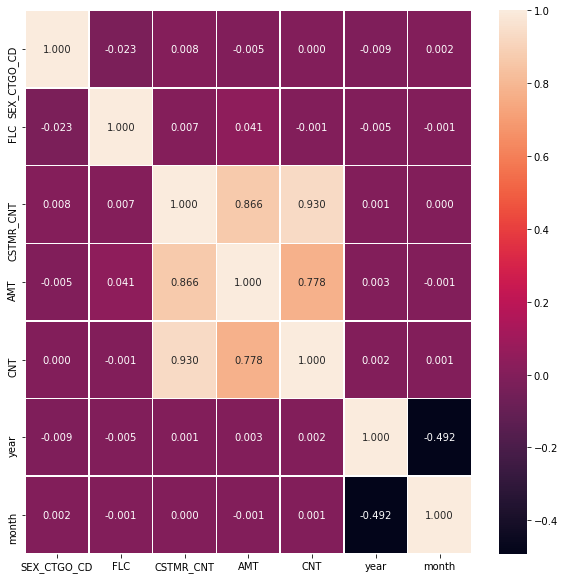

In [314]:
plt.figure(figsize=(10,10))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.3f', linewidths=.5)

분석 결과 CSTMR_CNT와 CNT를 제외한 변수들은 AMT와의 상관도가 낮다.

In [315]:
df = data.copy()
df = df.drop(['HOM_SIDO_NM','CARD_CCG_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD', 'FLC'], axis=1)

In [316]:
df

CARD_SIDO_NM STD_CLSS_NM  CSTMR_CNT      AMT  CNT  year  month
0                  강원  건강보조식품 소매업          4   311200    4  2019      1
1                  강원  건강보조식품 소매업          7  1374500    8  2019      1
2                  강원  건강보조식품 소매업          6   818700    6  2019      1
3                  강원  건강보조식품 소매업          4  1717000    5  2019      1
4                  강원  건강보조식품 소매업          3  1047300    3  2019      1
...               ...         ...        ...      ...  ...   ...    ...
24697787           충북    휴양콘도 운영업          3    43300    4  2020      3
24697788           충북    휴양콘도 운영업          3    35000    3  2020      3
24697789           충북    휴양콘도 운영업          4   188000    6  2020      3
24697790           충북    휴양콘도 운영업          4    99000    6  2020      3
24697791           충북    휴양콘도 운영업          3   194000    3  2020      3

[24697792 rows x 7 columns]

#### 4) 이상한 데이터 제거

In [317]:
df[df['AMT']<2000]

CARD_SIDO_NM            STD_CLSS_NM  CSTMR_CNT   AMT  CNT  year  \
234726             경기           기타 대형 종합 소매업          4   900    4  2019   
877390             서울              내항 여객 운송업          3   500    1  2019   
1001180            서울                수산물 소매업          9  1000   10  2019   
1423635            전북     스포츠 및 레크레이션 용품 임대업          3    40    3  2019   
1423637            전북     스포츠 및 레크레이션 용품 임대업          5    90    5  2019   
...               ...                    ...        ...   ...  ...   ...   
23333552           제주              정기 항공 운송업          3  1400    1  2020   
23698536           경기                   슈퍼마켓          3   730    2  2020   
24069417           서울           그외 기타 종합 소매업          4   200    1  2020   
24126444           서울  피자 햄버거 샌드위치 및 유사 음식점업          3  1600    4  2020   
24593106           제주              정기 항공 운송업          4   300    2  2020   

          month  
234726        1  
877390        1  
1001180       1  
1423635       1  
1423637       1  
...         ...  
23333552      2  
23698536      3  
24069417      3  
24126444      3  
24593106      3  

[91 rows x 7 columns]

In [318]:
idx = df[df['AMT']<2000].index
df = df.drop(idx)
df

CARD_SIDO_NM STD_CLSS_NM  CSTMR_CNT      AMT  CNT  year  month
0                  강원  건강보조식품 소매업          4   311200    4  2019      1
1                  강원  건강보조식품 소매업          7  1374500    8  2019      1
2                  강원  건강보조식품 소매업          6   818700    6  2019      1
3                  강원  건강보조식품 소매업          4  1717000    5  2019      1
4                  강원  건강보조식품 소매업          3  1047300    3  2019      1
...               ...         ...        ...      ...  ...   ...    ...
24697787           충북    휴양콘도 운영업          3    43300    4  2020      3
24697788           충북    휴양콘도 운영업          3    35000    3  2020      3
24697789           충북    휴양콘도 운영업          4   188000    6  2020      3
24697790           충북    휴양콘도 운영업          4    99000    6  2020      3
24697791           충북    휴양콘도 운영업          3   194000    3  2020      3

[24697701 rows x 7 columns]

40원, 90원등 작은 금액이 결제된 데이터들이 보여 2000원 미만으로 결제된 목록을 알아보았다.

이상치를 완전히 제거하기 위해 2000원 미만의 데이터들을 삭제하였다.

#### 6) 데이터 묶음

In [384]:
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)
df

CARD_SIDO_NM STD_CLSS_NM  year  month  CSTMR_CNT        AMT   CNT
0              강원  건강보조식품 소매업  2019      1       1080  148354746  1128
1              강원  건강보조식품 소매업  2019      2       1125  146715871  1157
2              강원  건강보조식품 소매업  2019      3        965  109439025  1020
3              강원  건강보조식품 소매업  2019      4        981  106548473  1042
4              강원  건강보조식품 소매업  2019      5       1181  148115738  1235
...           ...         ...   ...    ...        ...        ...   ...
9433           충북    휴양콘도 운영업  2019     11       1405  124117555  2204
9434           충북    휴양콘도 운영업  2019     12       1618  139568962  2539
9435           충북    휴양콘도 운영업  2020      1       2385  222073112  3743
9436           충북    휴양콘도 운영업  2020      2        588   47085830   913
9437           충북    휴양콘도 운영업  2020      3        115   12733490   182

[9438 rows x 7 columns]

#### 7) 라벨인코딩

In [488]:
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [489]:
df_num

CARD_SIDO_NM  STD_CLSS_NM  year  month  CSTMR_CNT        AMT   CNT
0                0            0  2019      1       1080  148354746  1128
1                0            0  2019      2       1125  146715871  1157
2                0            0  2019      3        965  109439025  1020
3                0            0  2019      4        981  106548473  1042
4                0            0  2019      5       1181  148115738  1235
...            ...          ...   ...    ...        ...        ...   ...
9433            16           40  2019     11       1405  124117555  2204
9434            16           40  2019     12       1618  139568962  2539
9435            16           40  2020      1       2385  222073112  3743
9436            16           40  2020      2        588   47085830   913
9437            16           40  2020      3        115   12733490   182

[9438 rows x 7 columns]

In [490]:
df_num = df_num[df_num['month'] < 8]
df_num

CARD_SIDO_NM  STD_CLSS_NM  year  month  CSTMR_CNT        AMT   CNT
0                0            0  2019      1       1080  148354746  1128
1                0            0  2019      2       1125  146715871  1157
2                0            0  2019      3        965  109439025  1020
3                0            0  2019      4        981  106548473  1042
4                0            0  2019      5       1181  148115738  1235
...            ...          ...   ...    ...        ...        ...   ...
9428            16           40  2019      6       1535  141948888  2626
9429            16           40  2019      7       1894  206980154  3236
9435            16           40  2020      1       2385  222073112  3743
9436            16           40  2020      2        588   47085830   913
9437            16           40  2020      3        115   12733490   182

[6289 rows x 7 columns]

#### 7) AMT 확인

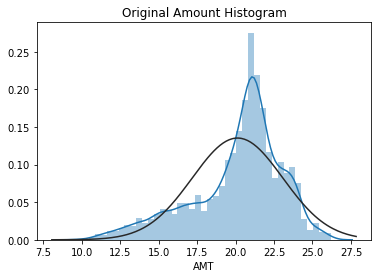

In [448]:
log_AMT = np.log1p(df_num['AMT'])
#df_num.insert(0,'log_AMT', log_AMT)
#df_num.drop('AMT', axis=1 , inplace=True)

plt.figure(figsize=(6,4))
plt.title('Original Amount Histogram')
sns.distplot(log_AMT,fit=norm)

## 3. LightGBM Regressor

In [491]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, GridSearchCV
lgbm_Card = LGBMRegressor()

In [492]:
train_features = df_num.drop(['AMT','CSTMR_CNT','CNT'], axis=1)
train_target = np.log1p(df_num['AMT'])
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.2, random_state=0)

In [493]:
train_target

0       18.815117
1       18.804008
2       18.510878
3       18.484111
4       18.813505
          ...    
9428    18.770978
9429    19.148133
9435    19.218517
9436    17.667483
9437    16.359746
Name: AMT, Length: 6289, dtype: float64

In [494]:
model = CatBoostRegressor(iterations=10000)
pool=Pool(data=X_train,label=y_train)
eval_set=(X_test,y_test)
model.fit(X_train,y_train,use_best_model=True,eval_set=eval_set)

Learning rate set to 0.014897
0:	learn: 2.9526079	test: 2.9167504	best: 2.9167504 (0)	total: 3.84ms	remaining: 38.4s
1:	learn: 2.9399841	test: 2.9036779	best: 2.9036779 (1)	total: 6.02ms	remaining: 30.1s
2:	learn: 2.9300647	test: 2.8931330	best: 2.8931330 (2)	total: 8.18ms	remaining: 27.3s
3:	learn: 2.9162150	test: 2.8785058	best: 2.8785058 (3)	total: 10.2ms	remaining: 25.5s
4:	learn: 2.9098689	test: 2.8721981	best: 2.8721981 (4)	total: 12.5ms	remaining: 24.9s
5:	learn: 2.9019882	test: 2.8641649	best: 2.8641649 (5)	total: 14.6ms	remaining: 24.4s
6:	learn: 2.8909422	test: 2.8528102	best: 2.8528102 (6)	total: 16.6ms	remaining: 23.7s
7:	learn: 2.8777578	test: 2.8388757	best: 2.8388757 (7)	total: 18.7ms	remaining: 23.3s
8:	learn: 2.8690887	test: 2.8300247	best: 2.8300247 (8)	total: 20.8ms	remaining: 23.1s
9:	learn: 2.8590179	test: 2.8193421	best: 2.8193421 (9)	total: 23ms	remaining: 23s
10:	learn: 2.8515378	test: 2.8113524	best: 2.8113524 (10)	total: 25.1ms	remaining: 22.8s
11:	learn: 2.84

150:	learn: 2.0860057	test: 2.0351634	best: 2.0351634 (150)	total: 318ms	remaining: 20.7s
151:	learn: 2.0822481	test: 2.0311155	best: 2.0311155 (151)	total: 320ms	remaining: 20.7s
152:	learn: 2.0786232	test: 2.0276215	best: 2.0276215 (152)	total: 322ms	remaining: 20.7s
153:	learn: 2.0751305	test: 2.0242578	best: 2.0242578 (153)	total: 324ms	remaining: 20.7s
154:	learn: 2.0715833	test: 2.0198673	best: 2.0198673 (154)	total: 326ms	remaining: 20.7s
155:	learn: 2.0707570	test: 2.0190714	best: 2.0190714 (155)	total: 328ms	remaining: 20.7s
156:	learn: 2.0679475	test: 2.0161052	best: 2.0161052 (156)	total: 330ms	remaining: 20.7s
157:	learn: 2.0637399	test: 2.0113205	best: 2.0113205 (157)	total: 332ms	remaining: 20.7s
158:	learn: 2.0598818	test: 2.0072845	best: 2.0072845 (158)	total: 334ms	remaining: 20.7s
159:	learn: 2.0568829	test: 2.0047327	best: 2.0047327 (159)	total: 336ms	remaining: 20.7s
160:	learn: 2.0547224	test: 2.0029485	best: 2.0029485 (160)	total: 338ms	remaining: 20.7s
161:	learn

310:	learn: 1.6999187	test: 1.6522885	best: 1.6522885 (310)	total: 646ms	remaining: 20.1s
311:	learn: 1.6969795	test: 1.6502702	best: 1.6502702 (311)	total: 648ms	remaining: 20.1s
312:	learn: 1.6958535	test: 1.6493962	best: 1.6493962 (312)	total: 650ms	remaining: 20.1s
313:	learn: 1.6929111	test: 1.6456749	best: 1.6456749 (313)	total: 652ms	remaining: 20.1s
314:	learn: 1.6911436	test: 1.6436985	best: 1.6436985 (314)	total: 654ms	remaining: 20.1s
315:	learn: 1.6878505	test: 1.6400282	best: 1.6400282 (315)	total: 656ms	remaining: 20.1s
316:	learn: 1.6860088	test: 1.6381001	best: 1.6381001 (316)	total: 658ms	remaining: 20.1s
317:	learn: 1.6855150	test: 1.6376383	best: 1.6376383 (317)	total: 660ms	remaining: 20.1s
318:	learn: 1.6840123	test: 1.6358072	best: 1.6358072 (318)	total: 662ms	remaining: 20.1s
319:	learn: 1.6810212	test: 1.6320715	best: 1.6320715 (319)	total: 665ms	remaining: 20.1s
320:	learn: 1.6790381	test: 1.6306856	best: 1.6306856 (320)	total: 667ms	remaining: 20.1s
321:	learn

465:	learn: 1.4603485	test: 1.4220319	best: 1.4220319 (465)	total: 967ms	remaining: 19.8s
466:	learn: 1.4596023	test: 1.4214704	best: 1.4214704 (466)	total: 969ms	remaining: 19.8s
467:	learn: 1.4577733	test: 1.4198677	best: 1.4198677 (467)	total: 971ms	remaining: 19.8s
468:	learn: 1.4565671	test: 1.4184907	best: 1.4184907 (468)	total: 973ms	remaining: 19.8s
469:	learn: 1.4553463	test: 1.4171204	best: 1.4171204 (469)	total: 975ms	remaining: 19.8s
470:	learn: 1.4549489	test: 1.4168483	best: 1.4168483 (470)	total: 977ms	remaining: 19.8s
471:	learn: 1.4537026	test: 1.4156390	best: 1.4156390 (471)	total: 979ms	remaining: 19.8s
472:	learn: 1.4525934	test: 1.4145908	best: 1.4145908 (472)	total: 981ms	remaining: 19.8s
473:	learn: 1.4517133	test: 1.4138060	best: 1.4138060 (473)	total: 983ms	remaining: 19.8s
474:	learn: 1.4509179	test: 1.4131997	best: 1.4131997 (474)	total: 985ms	remaining: 19.8s
475:	learn: 1.4485257	test: 1.4116811	best: 1.4116811 (475)	total: 987ms	remaining: 19.8s
476:	learn

618:	learn: 1.2931713	test: 1.2724785	best: 1.2724785 (618)	total: 1.28s	remaining: 19.5s
619:	learn: 1.2925481	test: 1.2721069	best: 1.2721069 (619)	total: 1.29s	remaining: 19.5s
620:	learn: 1.2911608	test: 1.2703656	best: 1.2703656 (620)	total: 1.29s	remaining: 19.5s
621:	learn: 1.2899181	test: 1.2687646	best: 1.2687646 (621)	total: 1.29s	remaining: 19.5s
622:	learn: 1.2886509	test: 1.2673618	best: 1.2673618 (622)	total: 1.29s	remaining: 19.5s
623:	learn: 1.2880994	test: 1.2669356	best: 1.2669356 (623)	total: 1.3s	remaining: 19.5s
624:	learn: 1.2866376	test: 1.2663277	best: 1.2663277 (624)	total: 1.3s	remaining: 19.5s
625:	learn: 1.2852306	test: 1.2646238	best: 1.2646238 (625)	total: 1.3s	remaining: 19.5s
626:	learn: 1.2838629	test: 1.2629655	best: 1.2629655 (626)	total: 1.3s	remaining: 19.5s
627:	learn: 1.2830916	test: 1.2621756	best: 1.2621756 (627)	total: 1.3s	remaining: 19.5s
628:	learn: 1.2824993	test: 1.2617933	best: 1.2617933 (628)	total: 1.31s	remaining: 19.5s
629:	learn: 1.2

771:	learn: 1.1658049	test: 1.1503929	best: 1.1503929 (771)	total: 1.61s	remaining: 19.2s
772:	learn: 1.1648533	test: 1.1498374	best: 1.1498374 (772)	total: 1.61s	remaining: 19.2s
773:	learn: 1.1639255	test: 1.1492964	best: 1.1492964 (773)	total: 1.61s	remaining: 19.2s
774:	learn: 1.1629388	test: 1.1483954	best: 1.1483954 (774)	total: 1.61s	remaining: 19.2s
775:	learn: 1.1620753	test: 1.1475807	best: 1.1475807 (775)	total: 1.62s	remaining: 19.2s
776:	learn: 1.1614318	test: 1.1467220	best: 1.1467220 (776)	total: 1.62s	remaining: 19.2s
777:	learn: 1.1606879	test: 1.1459387	best: 1.1459387 (777)	total: 1.62s	remaining: 19.2s
778:	learn: 1.1600125	test: 1.1451872	best: 1.1451872 (778)	total: 1.62s	remaining: 19.2s
779:	learn: 1.1594581	test: 1.1447744	best: 1.1447744 (779)	total: 1.63s	remaining: 19.2s
780:	learn: 1.1588857	test: 1.1443372	best: 1.1443372 (780)	total: 1.63s	remaining: 19.2s
781:	learn: 1.1585448	test: 1.1440855	best: 1.1440855 (781)	total: 1.63s	remaining: 19.2s
782:	learn

922:	learn: 1.0680609	test: 1.0685347	best: 1.0685347 (922)	total: 1.93s	remaining: 19s
923:	learn: 1.0673486	test: 1.0677189	best: 1.0677189 (923)	total: 1.93s	remaining: 19s
924:	learn: 1.0671043	test: 1.0675359	best: 1.0675359 (924)	total: 1.93s	remaining: 19s
925:	learn: 1.0664096	test: 1.0669679	best: 1.0669679 (925)	total: 1.93s	remaining: 19s
926:	learn: 1.0655252	test: 1.0665806	best: 1.0665806 (926)	total: 1.94s	remaining: 19s
927:	learn: 1.0647979	test: 1.0658666	best: 1.0658666 (927)	total: 1.94s	remaining: 19s
928:	learn: 1.0641123	test: 1.0653145	best: 1.0653145 (928)	total: 1.94s	remaining: 19s
929:	learn: 1.0633601	test: 1.0646288	best: 1.0646288 (929)	total: 1.94s	remaining: 19s
930:	learn: 1.0625868	test: 1.0639260	best: 1.0639260 (930)	total: 1.95s	remaining: 19s
931:	learn: 1.0620744	test: 1.0633608	best: 1.0633608 (931)	total: 1.95s	remaining: 19s
932:	learn: 1.0616175	test: 1.0628122	best: 1.0628122 (932)	total: 1.95s	remaining: 19s
933:	learn: 1.0608630	test: 1.06

1077:	learn: 0.9894519	test: 1.0085941	best: 1.0085941 (1077)	total: 2.25s	remaining: 18.6s
1078:	learn: 0.9892816	test: 1.0083660	best: 1.0083660 (1078)	total: 2.25s	remaining: 18.6s
1079:	learn: 0.9890970	test: 1.0082185	best: 1.0082185 (1079)	total: 2.26s	remaining: 18.6s
1080:	learn: 0.9887389	test: 1.0079480	best: 1.0079480 (1080)	total: 2.26s	remaining: 18.6s
1081:	learn: 0.9882212	test: 1.0074119	best: 1.0074119 (1081)	total: 2.26s	remaining: 18.6s
1082:	learn: 0.9876247	test: 1.0072292	best: 1.0072292 (1082)	total: 2.26s	remaining: 18.6s
1083:	learn: 0.9871215	test: 1.0067073	best: 1.0067073 (1083)	total: 2.26s	remaining: 18.6s
1084:	learn: 0.9866325	test: 1.0061995	best: 1.0061995 (1084)	total: 2.27s	remaining: 18.6s
1085:	learn: 0.9861408	test: 1.0057097	best: 1.0057097 (1085)	total: 2.27s	remaining: 18.6s
1086:	learn: 0.9856051	test: 1.0055747	best: 1.0055747 (1086)	total: 2.27s	remaining: 18.6s
1087:	learn: 0.9853125	test: 1.0052534	best: 1.0052534 (1087)	total: 2.27s	remai

1230:	learn: 0.9319766	test: 0.9649774	best: 0.9649774 (1230)	total: 2.57s	remaining: 18.3s
1231:	learn: 0.9314163	test: 0.9644773	best: 0.9644773 (1231)	total: 2.57s	remaining: 18.3s
1232:	learn: 0.9309626	test: 0.9644031	best: 0.9644031 (1232)	total: 2.58s	remaining: 18.3s
1233:	learn: 0.9308303	test: 0.9642375	best: 0.9642375 (1233)	total: 2.58s	remaining: 18.3s
1234:	learn: 0.9307110	test: 0.9642234	best: 0.9642234 (1234)	total: 2.58s	remaining: 18.3s
1235:	learn: 0.9305242	test: 0.9641350	best: 0.9641350 (1235)	total: 2.58s	remaining: 18.3s
1236:	learn: 0.9301159	test: 0.9636701	best: 0.9636701 (1236)	total: 2.58s	remaining: 18.3s
1237:	learn: 0.9296808	test: 0.9635692	best: 0.9635692 (1237)	total: 2.59s	remaining: 18.3s
1238:	learn: 0.9294824	test: 0.9634300	best: 0.9634300 (1238)	total: 2.59s	remaining: 18.3s
1239:	learn: 0.9290777	test: 0.9630473	best: 0.9630473 (1239)	total: 2.59s	remaining: 18.3s
1240:	learn: 0.9288135	test: 0.9627265	best: 0.9627265 (1240)	total: 2.59s	remai

1386:	learn: 0.8849408	test: 0.9289871	best: 0.9289871 (1386)	total: 2.9s	remaining: 18s
1387:	learn: 0.8844076	test: 0.9284507	best: 0.9284507 (1387)	total: 2.9s	remaining: 18s
1388:	learn: 0.8842325	test: 0.9284137	best: 0.9284137 (1388)	total: 2.9s	remaining: 18s
1389:	learn: 0.8841230	test: 0.9282727	best: 0.9282727 (1389)	total: 2.9s	remaining: 18s
1390:	learn: 0.8837347	test: 0.9276686	best: 0.9276686 (1390)	total: 2.9s	remaining: 18s
1391:	learn: 0.8833643	test: 0.9273737	best: 0.9273737 (1391)	total: 2.91s	remaining: 18s
1392:	learn: 0.8832217	test: 0.9272777	best: 0.9272777 (1392)	total: 2.91s	remaining: 18s
1393:	learn: 0.8829995	test: 0.9270608	best: 0.9270608 (1393)	total: 2.91s	remaining: 18s
1394:	learn: 0.8826199	test: 0.9264699	best: 0.9264699 (1394)	total: 2.91s	remaining: 18s
1395:	learn: 0.8822492	test: 0.9258924	best: 0.9258924 (1395)	total: 2.91s	remaining: 18s
1396:	learn: 0.8817262	test: 0.9253660	best: 0.9253660 (1396)	total: 2.92s	remaining: 18s
1397:	learn: 0.

1540:	learn: 0.8436958	test: 0.8980043	best: 0.8980043 (1540)	total: 3.22s	remaining: 17.7s
1541:	learn: 0.8435156	test: 0.8978012	best: 0.8978012 (1541)	total: 3.22s	remaining: 17.7s
1542:	learn: 0.8433390	test: 0.8976390	best: 0.8976390 (1542)	total: 3.23s	remaining: 17.7s
1543:	learn: 0.8431433	test: 0.8974394	best: 0.8974394 (1543)	total: 3.23s	remaining: 17.7s
1544:	learn: 0.8429843	test: 0.8973719	best: 0.8973719 (1544)	total: 3.23s	remaining: 17.7s
1545:	learn: 0.8426269	test: 0.8968795	best: 0.8968795 (1545)	total: 3.23s	remaining: 17.7s
1546:	learn: 0.8424289	test: 0.8967755	best: 0.8967755 (1546)	total: 3.23s	remaining: 17.7s
1547:	learn: 0.8422476	test: 0.8966827	best: 0.8966827 (1547)	total: 3.23s	remaining: 17.7s
1548:	learn: 0.8421395	test: 0.8966254	best: 0.8966254 (1548)	total: 3.24s	remaining: 17.7s
1549:	learn: 0.8420432	test: 0.8965015	best: 0.8965015 (1549)	total: 3.24s	remaining: 17.7s
1550:	learn: 0.8417568	test: 0.8962380	best: 0.8962380 (1550)	total: 3.24s	remai

1689:	learn: 0.8109401	test: 0.8758499	best: 0.8758499 (1689)	total: 3.54s	remaining: 17.4s
1690:	learn: 0.8108036	test: 0.8757773	best: 0.8757773 (1690)	total: 3.54s	remaining: 17.4s
1691:	learn: 0.8107026	test: 0.8757345	best: 0.8757345 (1691)	total: 3.54s	remaining: 17.4s
1692:	learn: 0.8104394	test: 0.8754910	best: 0.8754910 (1692)	total: 3.54s	remaining: 17.4s
1693:	learn: 0.8099909	test: 0.8751789	best: 0.8751789 (1693)	total: 3.54s	remaining: 17.4s
1694:	learn: 0.8098193	test: 0.8750814	best: 0.8750814 (1694)	total: 3.55s	remaining: 17.4s
1695:	learn: 0.8096114	test: 0.8748187	best: 0.8748187 (1695)	total: 3.55s	remaining: 17.4s
1696:	learn: 0.8094172	test: 0.8746191	best: 0.8746191 (1696)	total: 3.55s	remaining: 17.4s
1697:	learn: 0.8088875	test: 0.8743244	best: 0.8743244 (1697)	total: 3.55s	remaining: 17.4s
1698:	learn: 0.8088080	test: 0.8742972	best: 0.8742972 (1698)	total: 3.56s	remaining: 17.4s
1699:	learn: 0.8086530	test: 0.8741778	best: 0.8741778 (1699)	total: 3.56s	remai

1842:	learn: 0.7828024	test: 0.8573881	best: 0.8573881 (1842)	total: 3.86s	remaining: 17.1s
1843:	learn: 0.7826569	test: 0.8572531	best: 0.8572531 (1843)	total: 3.86s	remaining: 17.1s
1844:	learn: 0.7824777	test: 0.8570677	best: 0.8570677 (1844)	total: 3.86s	remaining: 17.1s
1845:	learn: 0.7823619	test: 0.8570691	best: 0.8570677 (1844)	total: 3.87s	remaining: 17.1s
1846:	learn: 0.7820320	test: 0.8570432	best: 0.8570432 (1846)	total: 3.87s	remaining: 17.1s
1847:	learn: 0.7818738	test: 0.8570524	best: 0.8570432 (1846)	total: 3.87s	remaining: 17.1s
1848:	learn: 0.7817035	test: 0.8568340	best: 0.8568340 (1848)	total: 3.87s	remaining: 17.1s
1849:	learn: 0.7814705	test: 0.8565363	best: 0.8565363 (1849)	total: 3.88s	remaining: 17.1s
1850:	learn: 0.7813849	test: 0.8564482	best: 0.8564482 (1850)	total: 3.88s	remaining: 17.1s
1851:	learn: 0.7812973	test: 0.8563767	best: 0.8563767 (1851)	total: 3.88s	remaining: 17.1s
1852:	learn: 0.7812368	test: 0.8563798	best: 0.8563767 (1851)	total: 3.88s	remai

1996:	learn: 0.7582100	test: 0.8406119	best: 0.8406119 (1996)	total: 4.18s	remaining: 16.8s
1997:	learn: 0.7581103	test: 0.8405473	best: 0.8405473 (1997)	total: 4.18s	remaining: 16.8s
1998:	learn: 0.7579931	test: 0.8404825	best: 0.8404825 (1998)	total: 4.18s	remaining: 16.7s
1999:	learn: 0.7578759	test: 0.8404278	best: 0.8404278 (1999)	total: 4.19s	remaining: 16.7s
2000:	learn: 0.7577534	test: 0.8403855	best: 0.8403855 (2000)	total: 4.19s	remaining: 16.7s
2001:	learn: 0.7576945	test: 0.8403636	best: 0.8403636 (2001)	total: 4.19s	remaining: 16.7s
2002:	learn: 0.7575993	test: 0.8403062	best: 0.8403062 (2002)	total: 4.19s	remaining: 16.7s
2003:	learn: 0.7574809	test: 0.8402684	best: 0.8402684 (2003)	total: 4.2s	remaining: 16.7s
2004:	learn: 0.7573930	test: 0.8402206	best: 0.8402206 (2004)	total: 4.2s	remaining: 16.7s
2005:	learn: 0.7571540	test: 0.8400906	best: 0.8400906 (2005)	total: 4.2s	remaining: 16.7s
2006:	learn: 0.7570311	test: 0.8399329	best: 0.8399329 (2006)	total: 4.2s	remaining

2150:	learn: 0.7355793	test: 0.8258983	best: 0.8258983 (2150)	total: 4.5s	remaining: 16.4s
2151:	learn: 0.7354430	test: 0.8258583	best: 0.8258583 (2151)	total: 4.5s	remaining: 16.4s
2152:	learn: 0.7353549	test: 0.8258208	best: 0.8258208 (2152)	total: 4.51s	remaining: 16.4s
2153:	learn: 0.7352949	test: 0.8257877	best: 0.8257877 (2153)	total: 4.51s	remaining: 16.4s
2154:	learn: 0.7352005	test: 0.8257388	best: 0.8257388 (2154)	total: 4.51s	remaining: 16.4s
2155:	learn: 0.7351020	test: 0.8256124	best: 0.8256124 (2155)	total: 4.51s	remaining: 16.4s
2156:	learn: 0.7350137	test: 0.8255306	best: 0.8255306 (2156)	total: 4.51s	remaining: 16.4s
2157:	learn: 0.7349538	test: 0.8255001	best: 0.8255001 (2157)	total: 4.52s	remaining: 16.4s
2158:	learn: 0.7348983	test: 0.8254631	best: 0.8254631 (2158)	total: 4.52s	remaining: 16.4s
2159:	learn: 0.7347491	test: 0.8254017	best: 0.8254017 (2159)	total: 4.52s	remaining: 16.4s
2160:	learn: 0.7346507	test: 0.8253249	best: 0.8253249 (2160)	total: 4.52s	remaini

2305:	learn: 0.7155326	test: 0.8128469	best: 0.8128469 (2305)	total: 4.83s	remaining: 16.1s
2306:	learn: 0.7154263	test: 0.8128323	best: 0.8128323 (2306)	total: 4.83s	remaining: 16.1s
2307:	learn: 0.7153111	test: 0.8128056	best: 0.8128056 (2307)	total: 4.83s	remaining: 16.1s
2308:	learn: 0.7152194	test: 0.8127683	best: 0.8127683 (2308)	total: 4.83s	remaining: 16.1s
2309:	learn: 0.7151004	test: 0.8127019	best: 0.8127019 (2309)	total: 4.83s	remaining: 16.1s
2310:	learn: 0.7147177	test: 0.8125245	best: 0.8125245 (2310)	total: 4.84s	remaining: 16.1s
2311:	learn: 0.7146260	test: 0.8124652	best: 0.8124652 (2311)	total: 4.84s	remaining: 16.1s
2312:	learn: 0.7144814	test: 0.8122861	best: 0.8122861 (2312)	total: 4.84s	remaining: 16.1s
2313:	learn: 0.7144049	test: 0.8121946	best: 0.8121946 (2313)	total: 4.84s	remaining: 16.1s
2314:	learn: 0.7142367	test: 0.8121633	best: 0.8121633 (2314)	total: 4.84s	remaining: 16.1s
2315:	learn: 0.7141869	test: 0.8121356	best: 0.8121356 (2315)	total: 4.85s	remai

2461:	learn: 0.6963312	test: 0.8034750	best: 0.8034750 (2461)	total: 5.15s	remaining: 15.8s
2462:	learn: 0.6962736	test: 0.8035244	best: 0.8034750 (2461)	total: 5.16s	remaining: 15.8s
2463:	learn: 0.6961993	test: 0.8034543	best: 0.8034543 (2463)	total: 5.16s	remaining: 15.8s
2464:	learn: 0.6961324	test: 0.8033735	best: 0.8033735 (2464)	total: 5.16s	remaining: 15.8s
2465:	learn: 0.6959771	test: 0.8032938	best: 0.8032938 (2465)	total: 5.16s	remaining: 15.8s
2466:	learn: 0.6959094	test: 0.8032691	best: 0.8032691 (2466)	total: 5.16s	remaining: 15.8s
2467:	learn: 0.6957659	test: 0.8031863	best: 0.8031863 (2467)	total: 5.17s	remaining: 15.8s
2468:	learn: 0.6956952	test: 0.8031153	best: 0.8031153 (2468)	total: 5.17s	remaining: 15.8s
2469:	learn: 0.6956186	test: 0.8030830	best: 0.8030830 (2469)	total: 5.17s	remaining: 15.8s
2470:	learn: 0.6955195	test: 0.8030355	best: 0.8030355 (2470)	total: 5.17s	remaining: 15.8s
2471:	learn: 0.6954052	test: 0.8030047	best: 0.8030047 (2471)	total: 5.17s	remai

2616:	learn: 0.6790322	test: 0.7910839	best: 0.7910839 (2616)	total: 5.48s	remaining: 15.5s
2617:	learn: 0.6789169	test: 0.7909826	best: 0.7909826 (2617)	total: 5.48s	remaining: 15.5s
2618:	learn: 0.6788658	test: 0.7909076	best: 0.7909076 (2618)	total: 5.48s	remaining: 15.5s
2619:	learn: 0.6787775	test: 0.7909171	best: 0.7909076 (2618)	total: 5.49s	remaining: 15.4s
2620:	learn: 0.6787179	test: 0.7908798	best: 0.7908798 (2620)	total: 5.49s	remaining: 15.4s
2621:	learn: 0.6786844	test: 0.7908689	best: 0.7908689 (2621)	total: 5.49s	remaining: 15.4s
2622:	learn: 0.6784504	test: 0.7907540	best: 0.7907540 (2622)	total: 5.49s	remaining: 15.4s
2623:	learn: 0.6783016	test: 0.7906537	best: 0.7906537 (2623)	total: 5.49s	remaining: 15.4s
2624:	learn: 0.6781546	test: 0.7905691	best: 0.7905691 (2624)	total: 5.5s	remaining: 15.4s
2625:	learn: 0.6780251	test: 0.7904274	best: 0.7904274 (2625)	total: 5.5s	remaining: 15.4s
2626:	learn: 0.6779503	test: 0.7903649	best: 0.7903649 (2626)	total: 5.5s	remainin

2767:	learn: 0.6643726	test: 0.7812042	best: 0.7812042 (2767)	total: 5.79s	remaining: 15.1s
2768:	learn: 0.6643215	test: 0.7811775	best: 0.7811775 (2768)	total: 5.8s	remaining: 15.1s
2769:	learn: 0.6642636	test: 0.7811147	best: 0.7811147 (2769)	total: 5.8s	remaining: 15.1s
2770:	learn: 0.6641299	test: 0.7809917	best: 0.7809917 (2770)	total: 5.8s	remaining: 15.1s
2771:	learn: 0.6639583	test: 0.7810058	best: 0.7809917 (2770)	total: 5.8s	remaining: 15.1s
2772:	learn: 0.6638892	test: 0.7809604	best: 0.7809604 (2772)	total: 5.81s	remaining: 15.1s
2773:	learn: 0.6637233	test: 0.7809469	best: 0.7809469 (2773)	total: 5.81s	remaining: 15.1s
2774:	learn: 0.6635680	test: 0.7809515	best: 0.7809469 (2773)	total: 5.81s	remaining: 15.1s
2775:	learn: 0.6634513	test: 0.7810143	best: 0.7809469 (2773)	total: 5.81s	remaining: 15.1s
2776:	learn: 0.6633895	test: 0.7809277	best: 0.7809277 (2776)	total: 5.81s	remaining: 15.1s
2777:	learn: 0.6632149	test: 0.7808280	best: 0.7808280 (2777)	total: 5.82s	remaining

2918:	learn: 0.6511003	test: 0.7734977	best: 0.7734977 (2918)	total: 6.11s	remaining: 14.8s
2919:	learn: 0.6510477	test: 0.7734799	best: 0.7734799 (2919)	total: 6.12s	remaining: 14.8s
2920:	learn: 0.6510135	test: 0.7734836	best: 0.7734799 (2919)	total: 6.12s	remaining: 14.8s
2921:	learn: 0.6509833	test: 0.7734681	best: 0.7734681 (2921)	total: 6.12s	remaining: 14.8s
2922:	learn: 0.6509119	test: 0.7733895	best: 0.7733895 (2922)	total: 6.12s	remaining: 14.8s
2923:	learn: 0.6508108	test: 0.7733203	best: 0.7733203 (2923)	total: 6.13s	remaining: 14.8s
2924:	learn: 0.6507466	test: 0.7732650	best: 0.7732650 (2924)	total: 6.13s	remaining: 14.8s
2925:	learn: 0.6506434	test: 0.7731489	best: 0.7731489 (2925)	total: 6.13s	remaining: 14.8s
2926:	learn: 0.6505280	test: 0.7731027	best: 0.7731027 (2926)	total: 6.13s	remaining: 14.8s
2927:	learn: 0.6504223	test: 0.7730152	best: 0.7730152 (2927)	total: 6.13s	remaining: 14.8s
2928:	learn: 0.6503595	test: 0.7730291	best: 0.7730152 (2927)	total: 6.14s	remai

3071:	learn: 0.6377571	test: 0.7653108	best: 0.7652828 (3070)	total: 6.43s	remaining: 14.5s
3072:	learn: 0.6376615	test: 0.7652121	best: 0.7652121 (3072)	total: 6.44s	remaining: 14.5s
3073:	learn: 0.6375967	test: 0.7651815	best: 0.7651815 (3073)	total: 6.44s	remaining: 14.5s
3074:	learn: 0.6375063	test: 0.7651042	best: 0.7651042 (3074)	total: 6.44s	remaining: 14.5s
3075:	learn: 0.6374140	test: 0.7650000	best: 0.7650000 (3075)	total: 6.44s	remaining: 14.5s
3076:	learn: 0.6373708	test: 0.7650508	best: 0.7650000 (3075)	total: 6.45s	remaining: 14.5s
3077:	learn: 0.6372719	test: 0.7650032	best: 0.7650000 (3075)	total: 6.45s	remaining: 14.5s
3078:	learn: 0.6371349	test: 0.7648840	best: 0.7648840 (3078)	total: 6.45s	remaining: 14.5s
3079:	learn: 0.6370332	test: 0.7648121	best: 0.7648121 (3079)	total: 6.45s	remaining: 14.5s
3080:	learn: 0.6369469	test: 0.7647533	best: 0.7647533 (3080)	total: 6.46s	remaining: 14.5s
3081:	learn: 0.6368245	test: 0.7647679	best: 0.7647533 (3080)	total: 6.46s	remai

3225:	learn: 0.6237983	test: 0.7568235	best: 0.7568235 (3225)	total: 6.76s	remaining: 14.2s
3226:	learn: 0.6237366	test: 0.7568026	best: 0.7568026 (3226)	total: 6.76s	remaining: 14.2s
3227:	learn: 0.6236889	test: 0.7567973	best: 0.7567973 (3227)	total: 6.76s	remaining: 14.2s
3228:	learn: 0.6235601	test: 0.7566790	best: 0.7566790 (3228)	total: 6.76s	remaining: 14.2s
3229:	learn: 0.6235218	test: 0.7566657	best: 0.7566657 (3229)	total: 6.77s	remaining: 14.2s
3230:	learn: 0.6234683	test: 0.7566568	best: 0.7566568 (3230)	total: 6.77s	remaining: 14.2s
3231:	learn: 0.6232710	test: 0.7565014	best: 0.7565014 (3231)	total: 6.77s	remaining: 14.2s
3232:	learn: 0.6231801	test: 0.7564080	best: 0.7564080 (3232)	total: 6.77s	remaining: 14.2s
3233:	learn: 0.6230933	test: 0.7563510	best: 0.7563510 (3233)	total: 6.77s	remaining: 14.2s
3234:	learn: 0.6230355	test: 0.7563307	best: 0.7563307 (3234)	total: 6.78s	remaining: 14.2s
3235:	learn: 0.6229769	test: 0.7562974	best: 0.7562974 (3235)	total: 6.78s	remai

3379:	learn: 0.6117143	test: 0.7497033	best: 0.7497033 (3379)	total: 7.08s	remaining: 13.9s
3380:	learn: 0.6116243	test: 0.7495889	best: 0.7495889 (3380)	total: 7.08s	remaining: 13.9s
3381:	learn: 0.6113428	test: 0.7494967	best: 0.7494967 (3381)	total: 7.08s	remaining: 13.9s
3382:	learn: 0.6112287	test: 0.7493732	best: 0.7493732 (3382)	total: 7.09s	remaining: 13.9s
3383:	learn: 0.6111849	test: 0.7493414	best: 0.7493414 (3383)	total: 7.09s	remaining: 13.9s
3384:	learn: 0.6111446	test: 0.7493083	best: 0.7493083 (3384)	total: 7.09s	remaining: 13.9s
3385:	learn: 0.6110183	test: 0.7492450	best: 0.7492450 (3385)	total: 7.09s	remaining: 13.9s
3386:	learn: 0.6109425	test: 0.7492958	best: 0.7492450 (3385)	total: 7.09s	remaining: 13.9s
3387:	learn: 0.6108324	test: 0.7492517	best: 0.7492450 (3385)	total: 7.1s	remaining: 13.8s
3388:	learn: 0.6107827	test: 0.7492233	best: 0.7492233 (3388)	total: 7.1s	remaining: 13.8s
3389:	learn: 0.6106998	test: 0.7491069	best: 0.7491069 (3389)	total: 7.1s	remainin

3521:	learn: 0.6002278	test: 0.7434650	best: 0.7434650 (3521)	total: 7.39s	remaining: 13.6s
3522:	learn: 0.6001179	test: 0.7433591	best: 0.7433591 (3522)	total: 7.39s	remaining: 13.6s
3523:	learn: 0.5997084	test: 0.7430875	best: 0.7430875 (3523)	total: 7.39s	remaining: 13.6s
3524:	learn: 0.5994082	test: 0.7429634	best: 0.7429634 (3524)	total: 7.39s	remaining: 13.6s
3525:	learn: 0.5992746	test: 0.7428415	best: 0.7428415 (3525)	total: 7.4s	remaining: 13.6s
3526:	learn: 0.5990813	test: 0.7426579	best: 0.7426579 (3526)	total: 7.4s	remaining: 13.6s
3527:	learn: 0.5990211	test: 0.7426070	best: 0.7426070 (3527)	total: 7.4s	remaining: 13.6s
3528:	learn: 0.5989210	test: 0.7425686	best: 0.7425686 (3528)	total: 7.4s	remaining: 13.6s
3529:	learn: 0.5988705	test: 0.7425595	best: 0.7425595 (3529)	total: 7.4s	remaining: 13.6s
3530:	learn: 0.5988427	test: 0.7425543	best: 0.7425543 (3530)	total: 7.41s	remaining: 13.6s
3531:	learn: 0.5987999	test: 0.7425316	best: 0.7425316 (3531)	total: 7.41s	remaining:

3670:	learn: 0.5877947	test: 0.7372294	best: 0.7372294 (3670)	total: 7.7s	remaining: 13.3s
3671:	learn: 0.5877693	test: 0.7372040	best: 0.7372040 (3671)	total: 7.7s	remaining: 13.3s
3672:	learn: 0.5876720	test: 0.7371041	best: 0.7371041 (3672)	total: 7.7s	remaining: 13.3s
3673:	learn: 0.5875315	test: 0.7371560	best: 0.7371041 (3672)	total: 7.71s	remaining: 13.3s
3674:	learn: 0.5875099	test: 0.7371479	best: 0.7371041 (3672)	total: 7.71s	remaining: 13.3s
3675:	learn: 0.5874004	test: 0.7370955	best: 0.7370955 (3675)	total: 7.71s	remaining: 13.3s
3676:	learn: 0.5872900	test: 0.7370033	best: 0.7370033 (3676)	total: 7.71s	remaining: 13.3s
3677:	learn: 0.5871617	test: 0.7368805	best: 0.7368805 (3677)	total: 7.71s	remaining: 13.3s
3678:	learn: 0.5871170	test: 0.7368564	best: 0.7368564 (3678)	total: 7.72s	remaining: 13.3s
3679:	learn: 0.5870876	test: 0.7368414	best: 0.7368414 (3679)	total: 7.72s	remaining: 13.3s
3680:	learn: 0.5869794	test: 0.7367511	best: 0.7367511 (3680)	total: 7.72s	remainin

3819:	learn: 0.5758170	test: 0.7316642	best: 0.7316642 (3819)	total: 8.01s	remaining: 13s
3820:	learn: 0.5757564	test: 0.7316127	best: 0.7316127 (3820)	total: 8.02s	remaining: 13s
3821:	learn: 0.5756115	test: 0.7315415	best: 0.7315415 (3821)	total: 8.02s	remaining: 13s
3822:	learn: 0.5754906	test: 0.7314719	best: 0.7314719 (3822)	total: 8.02s	remaining: 13s
3823:	learn: 0.5754175	test: 0.7313723	best: 0.7313723 (3823)	total: 8.02s	remaining: 13s
3824:	learn: 0.5753527	test: 0.7313322	best: 0.7313322 (3824)	total: 8.02s	remaining: 13s
3825:	learn: 0.5752934	test: 0.7312939	best: 0.7312939 (3825)	total: 8.03s	remaining: 13s
3826:	learn: 0.5752551	test: 0.7313156	best: 0.7312939 (3825)	total: 8.03s	remaining: 12.9s
3827:	learn: 0.5751861	test: 0.7312424	best: 0.7312424 (3827)	total: 8.03s	remaining: 12.9s
3828:	learn: 0.5750420	test: 0.7311987	best: 0.7311987 (3828)	total: 8.03s	remaining: 12.9s
3829:	learn: 0.5749832	test: 0.7311969	best: 0.7311969 (3829)	total: 8.03s	remaining: 12.9s
38

3970:	learn: 0.5651165	test: 0.7255450	best: 0.7255450 (3970)	total: 8.33s	remaining: 12.6s
3971:	learn: 0.5650877	test: 0.7255182	best: 0.7255182 (3971)	total: 8.33s	remaining: 12.6s
3972:	learn: 0.5650610	test: 0.7255080	best: 0.7255080 (3972)	total: 8.33s	remaining: 12.6s
3973:	learn: 0.5648307	test: 0.7254602	best: 0.7254602 (3973)	total: 8.33s	remaining: 12.6s
3974:	learn: 0.5647773	test: 0.7254123	best: 0.7254123 (3974)	total: 8.34s	remaining: 12.6s
3975:	learn: 0.5647476	test: 0.7254102	best: 0.7254102 (3975)	total: 8.34s	remaining: 12.6s
3976:	learn: 0.5646265	test: 0.7253091	best: 0.7253091 (3976)	total: 8.34s	remaining: 12.6s
3977:	learn: 0.5646114	test: 0.7253155	best: 0.7253091 (3976)	total: 8.34s	remaining: 12.6s
3978:	learn: 0.5645736	test: 0.7252943	best: 0.7252943 (3978)	total: 8.34s	remaining: 12.6s
3979:	learn: 0.5645086	test: 0.7252672	best: 0.7252672 (3979)	total: 8.35s	remaining: 12.6s
3980:	learn: 0.5644369	test: 0.7252735	best: 0.7252672 (3979)	total: 8.35s	remai

4121:	learn: 0.5553245	test: 0.7210271	best: 0.7207836 (4114)	total: 8.64s	remaining: 12.3s
4122:	learn: 0.5552938	test: 0.7210159	best: 0.7207836 (4114)	total: 8.64s	remaining: 12.3s
4123:	learn: 0.5551470	test: 0.7212107	best: 0.7207836 (4114)	total: 8.64s	remaining: 12.3s
4124:	learn: 0.5550901	test: 0.7212616	best: 0.7207836 (4114)	total: 8.65s	remaining: 12.3s
4125:	learn: 0.5549047	test: 0.7212122	best: 0.7207836 (4114)	total: 8.65s	remaining: 12.3s
4126:	learn: 0.5548709	test: 0.7212053	best: 0.7207836 (4114)	total: 8.65s	remaining: 12.3s
4127:	learn: 0.5548226	test: 0.7211866	best: 0.7207836 (4114)	total: 8.65s	remaining: 12.3s
4128:	learn: 0.5547910	test: 0.7211763	best: 0.7207836 (4114)	total: 8.65s	remaining: 12.3s
4129:	learn: 0.5547443	test: 0.7211130	best: 0.7207836 (4114)	total: 8.66s	remaining: 12.3s
4130:	learn: 0.5546899	test: 0.7210285	best: 0.7207836 (4114)	total: 8.66s	remaining: 12.3s
4131:	learn: 0.5546295	test: 0.7211082	best: 0.7207836 (4114)	total: 8.66s	remai

4270:	learn: 0.5458645	test: 0.7163222	best: 0.7163085 (4269)	total: 8.96s	remaining: 12s
4271:	learn: 0.5457827	test: 0.7162531	best: 0.7162531 (4271)	total: 8.96s	remaining: 12s
4272:	learn: 0.5457337	test: 0.7162309	best: 0.7162309 (4272)	total: 8.96s	remaining: 12s
4273:	learn: 0.5456991	test: 0.7161987	best: 0.7161987 (4273)	total: 8.96s	remaining: 12s
4274:	learn: 0.5456754	test: 0.7161931	best: 0.7161931 (4274)	total: 8.96s	remaining: 12s
4275:	learn: 0.5456205	test: 0.7161796	best: 0.7161796 (4275)	total: 8.97s	remaining: 12s
4276:	learn: 0.5455475	test: 0.7160967	best: 0.7160967 (4276)	total: 8.97s	remaining: 12s
4277:	learn: 0.5455106	test: 0.7160656	best: 0.7160656 (4277)	total: 8.97s	remaining: 12s
4278:	learn: 0.5453392	test: 0.7160179	best: 0.7160179 (4278)	total: 8.97s	remaining: 12s
4279:	learn: 0.5452605	test: 0.7159680	best: 0.7159680 (4279)	total: 8.97s	remaining: 12s
4280:	learn: 0.5451564	test: 0.7158384	best: 0.7158384 (4280)	total: 8.98s	remaining: 12s
4281:	lear

4419:	learn: 0.5371245	test: 0.7126021	best: 0.7126021 (4419)	total: 9.27s	remaining: 11.7s
4420:	learn: 0.5370989	test: 0.7125864	best: 0.7125864 (4420)	total: 9.27s	remaining: 11.7s
4421:	learn: 0.5370427	test: 0.7125529	best: 0.7125529 (4421)	total: 9.27s	remaining: 11.7s
4422:	learn: 0.5369482	test: 0.7124691	best: 0.7124691 (4422)	total: 9.28s	remaining: 11.7s
4423:	learn: 0.5368706	test: 0.7123384	best: 0.7123384 (4423)	total: 9.28s	remaining: 11.7s
4424:	learn: 0.5368362	test: 0.7123216	best: 0.7123216 (4424)	total: 9.28s	remaining: 11.7s
4425:	learn: 0.5367888	test: 0.7122755	best: 0.7122755 (4425)	total: 9.28s	remaining: 11.7s
4426:	learn: 0.5367406	test: 0.7123652	best: 0.7122755 (4425)	total: 9.28s	remaining: 11.7s
4427:	learn: 0.5366501	test: 0.7123639	best: 0.7122755 (4425)	total: 9.29s	remaining: 11.7s
4428:	learn: 0.5366116	test: 0.7123388	best: 0.7122755 (4425)	total: 9.29s	remaining: 11.7s
4429:	learn: 0.5364798	test: 0.7125942	best: 0.7122755 (4425)	total: 9.29s	remai

4563:	learn: 0.5294128	test: 0.7088639	best: 0.7088583 (4562)	total: 9.58s	remaining: 11.4s
4564:	learn: 0.5293840	test: 0.7088367	best: 0.7088367 (4564)	total: 9.58s	remaining: 11.4s
4565:	learn: 0.5293608	test: 0.7088470	best: 0.7088367 (4564)	total: 9.58s	remaining: 11.4s
4566:	learn: 0.5293316	test: 0.7088201	best: 0.7088201 (4566)	total: 9.58s	remaining: 11.4s
4567:	learn: 0.5293038	test: 0.7088049	best: 0.7088049 (4567)	total: 9.58s	remaining: 11.4s
4568:	learn: 0.5292809	test: 0.7087958	best: 0.7087958 (4568)	total: 9.59s	remaining: 11.4s
4569:	learn: 0.5292577	test: 0.7087981	best: 0.7087958 (4568)	total: 9.59s	remaining: 11.4s
4570:	learn: 0.5291537	test: 0.7087511	best: 0.7087511 (4570)	total: 9.59s	remaining: 11.4s
4571:	learn: 0.5291169	test: 0.7087425	best: 0.7087425 (4571)	total: 9.59s	remaining: 11.4s
4572:	learn: 0.5290831	test: 0.7087644	best: 0.7087425 (4571)	total: 9.59s	remaining: 11.4s
4573:	learn: 0.5290537	test: 0.7087220	best: 0.7087220 (4573)	total: 9.6s	remain

4710:	learn: 0.5215684	test: 0.7054519	best: 0.7054519 (4710)	total: 9.89s	remaining: 11.1s
4711:	learn: 0.5215412	test: 0.7054423	best: 0.7054423 (4711)	total: 9.89s	remaining: 11.1s
4712:	learn: 0.5214269	test: 0.7054128	best: 0.7054128 (4712)	total: 9.89s	remaining: 11.1s
4713:	learn: 0.5213559	test: 0.7053830	best: 0.7053830 (4713)	total: 9.89s	remaining: 11.1s
4714:	learn: 0.5213342	test: 0.7053786	best: 0.7053786 (4714)	total: 9.9s	remaining: 11.1s
4715:	learn: 0.5213127	test: 0.7053622	best: 0.7053622 (4715)	total: 9.9s	remaining: 11.1s
4716:	learn: 0.5212167	test: 0.7053401	best: 0.7053401 (4716)	total: 9.9s	remaining: 11.1s
4717:	learn: 0.5211596	test: 0.7053247	best: 0.7053247 (4717)	total: 9.9s	remaining: 11.1s
4718:	learn: 0.5211179	test: 0.7053704	best: 0.7053247 (4717)	total: 9.9s	remaining: 11.1s
4719:	learn: 0.5210060	test: 0.7052687	best: 0.7052687 (4719)	total: 9.91s	remaining: 11.1s
4720:	learn: 0.5208251	test: 0.7052499	best: 0.7052499 (4720)	total: 9.91s	remaining:

4857:	learn: 0.5131104	test: 0.7022000	best: 0.7022000 (4857)	total: 10.2s	remaining: 10.8s
4858:	learn: 0.5130614	test: 0.7021499	best: 0.7021499 (4858)	total: 10.2s	remaining: 10.8s
4859:	learn: 0.5129321	test: 0.7020907	best: 0.7020907 (4859)	total: 10.2s	remaining: 10.8s
4860:	learn: 0.5129029	test: 0.7020921	best: 0.7020907 (4859)	total: 10.2s	remaining: 10.8s
4861:	learn: 0.5128462	test: 0.7020056	best: 0.7020056 (4861)	total: 10.2s	remaining: 10.8s
4862:	learn: 0.5128041	test: 0.7020045	best: 0.7020045 (4862)	total: 10.2s	remaining: 10.8s
4863:	learn: 0.5127641	test: 0.7019450	best: 0.7019450 (4863)	total: 10.2s	remaining: 10.8s
4864:	learn: 0.5127490	test: 0.7019302	best: 0.7019302 (4864)	total: 10.2s	remaining: 10.8s
4865:	learn: 0.5126840	test: 0.7019047	best: 0.7019047 (4865)	total: 10.2s	remaining: 10.8s
4866:	learn: 0.5126037	test: 0.7019040	best: 0.7019040 (4866)	total: 10.2s	remaining: 10.8s
4867:	learn: 0.5125676	test: 0.7018989	best: 0.7018989 (4867)	total: 10.2s	remai

5003:	learn: 0.5051080	test: 0.6995718	best: 0.6995718 (5003)	total: 10.5s	remaining: 10.5s
5004:	learn: 0.5050654	test: 0.6995357	best: 0.6995357 (5004)	total: 10.5s	remaining: 10.5s
5005:	learn: 0.5050033	test: 0.6994444	best: 0.6994444 (5005)	total: 10.5s	remaining: 10.5s
5006:	learn: 0.5049759	test: 0.6994779	best: 0.6994444 (5005)	total: 10.5s	remaining: 10.5s
5007:	learn: 0.5049042	test: 0.6994402	best: 0.6994402 (5007)	total: 10.5s	remaining: 10.5s
5008:	learn: 0.5048791	test: 0.6994460	best: 0.6994402 (5007)	total: 10.5s	remaining: 10.5s
5009:	learn: 0.5048157	test: 0.6993963	best: 0.6993963 (5009)	total: 10.5s	remaining: 10.5s
5010:	learn: 0.5046504	test: 0.6993452	best: 0.6993452 (5010)	total: 10.5s	remaining: 10.5s
5011:	learn: 0.5045953	test: 0.6993295	best: 0.6993295 (5011)	total: 10.5s	remaining: 10.5s
5012:	learn: 0.5045258	test: 0.6993303	best: 0.6993295 (5011)	total: 10.5s	remaining: 10.5s
5013:	learn: 0.5044948	test: 0.6992930	best: 0.6992930 (5013)	total: 10.5s	remai

5156:	learn: 0.4966489	test: 0.6969481	best: 0.6969481 (5156)	total: 10.8s	remaining: 10.2s
5157:	learn: 0.4966295	test: 0.6969539	best: 0.6969481 (5156)	total: 10.8s	remaining: 10.2s
5158:	learn: 0.4965929	test: 0.6969537	best: 0.6969481 (5156)	total: 10.8s	remaining: 10.2s
5159:	learn: 0.4965194	test: 0.6969531	best: 0.6969481 (5156)	total: 10.8s	remaining: 10.2s
5160:	learn: 0.4964961	test: 0.6969528	best: 0.6969481 (5156)	total: 10.8s	remaining: 10.2s
5161:	learn: 0.4964366	test: 0.6969294	best: 0.6969294 (5161)	total: 10.8s	remaining: 10.2s
5162:	learn: 0.4963649	test: 0.6969290	best: 0.6969290 (5162)	total: 10.8s	remaining: 10.2s
5163:	learn: 0.4963247	test: 0.6969250	best: 0.6969250 (5163)	total: 10.8s	remaining: 10.2s
5164:	learn: 0.4962666	test: 0.6969022	best: 0.6969022 (5164)	total: 10.8s	remaining: 10.2s
5165:	learn: 0.4962321	test: 0.6968689	best: 0.6968689 (5165)	total: 10.9s	remaining: 10.2s
5166:	learn: 0.4961456	test: 0.6967827	best: 0.6967827 (5166)	total: 10.9s	remai

5305:	learn: 0.4896266	test: 0.6941749	best: 0.6941650 (5302)	total: 11.1s	remaining: 9.86s
5306:	learn: 0.4896146	test: 0.6941763	best: 0.6941650 (5302)	total: 11.1s	remaining: 9.86s
5307:	learn: 0.4896053	test: 0.6941811	best: 0.6941650 (5302)	total: 11.2s	remaining: 9.86s
5308:	learn: 0.4895707	test: 0.6941520	best: 0.6941520 (5308)	total: 11.2s	remaining: 9.86s
5309:	learn: 0.4895267	test: 0.6940956	best: 0.6940956 (5309)	total: 11.2s	remaining: 9.85s
5310:	learn: 0.4894235	test: 0.6940821	best: 0.6940821 (5310)	total: 11.2s	remaining: 9.85s
5311:	learn: 0.4893876	test: 0.6940770	best: 0.6940770 (5311)	total: 11.2s	remaining: 9.85s
5312:	learn: 0.4893606	test: 0.6940110	best: 0.6940110 (5312)	total: 11.2s	remaining: 9.85s
5313:	learn: 0.4893199	test: 0.6940682	best: 0.6940110 (5312)	total: 11.2s	remaining: 9.84s
5314:	learn: 0.4892685	test: 0.6940530	best: 0.6940110 (5312)	total: 11.2s	remaining: 9.84s
5315:	learn: 0.4892443	test: 0.6940539	best: 0.6940110 (5312)	total: 11.2s	remai

5456:	learn: 0.4814026	test: 0.6910787	best: 0.6910787 (5456)	total: 11.5s	remaining: 9.55s
5457:	learn: 0.4813448	test: 0.6910137	best: 0.6910137 (5457)	total: 11.5s	remaining: 9.55s
5458:	learn: 0.4812815	test: 0.6909804	best: 0.6909804 (5458)	total: 11.5s	remaining: 9.54s
5459:	learn: 0.4812667	test: 0.6909801	best: 0.6909801 (5459)	total: 11.5s	remaining: 9.54s
5460:	learn: 0.4812554	test: 0.6909762	best: 0.6909762 (5460)	total: 11.5s	remaining: 9.54s
5461:	learn: 0.4812389	test: 0.6909637	best: 0.6909637 (5461)	total: 11.5s	remaining: 9.54s
5462:	learn: 0.4811052	test: 0.6909695	best: 0.6909637 (5461)	total: 11.5s	remaining: 9.54s
5463:	learn: 0.4810522	test: 0.6909492	best: 0.6909492 (5463)	total: 11.5s	remaining: 9.53s
5464:	learn: 0.4810202	test: 0.6909044	best: 0.6909044 (5464)	total: 11.5s	remaining: 9.53s
5465:	learn: 0.4810030	test: 0.6908943	best: 0.6908943 (5465)	total: 11.5s	remaining: 9.53s
5466:	learn: 0.4809443	test: 0.6908481	best: 0.6908481 (5466)	total: 11.5s	remai

5594:	learn: 0.4744903	test: 0.6885259	best: 0.6885259 (5594)	total: 11.8s	remaining: 9.27s
5595:	learn: 0.4744749	test: 0.6885091	best: 0.6885091 (5595)	total: 11.8s	remaining: 9.26s
5596:	learn: 0.4744076	test: 0.6884763	best: 0.6884763 (5596)	total: 11.8s	remaining: 9.26s
5597:	learn: 0.4742978	test: 0.6882972	best: 0.6882972 (5597)	total: 11.8s	remaining: 9.26s
5598:	learn: 0.4742542	test: 0.6882794	best: 0.6882794 (5598)	total: 11.8s	remaining: 9.26s
5599:	learn: 0.4742305	test: 0.6882616	best: 0.6882616 (5599)	total: 11.8s	remaining: 9.26s
5600:	learn: 0.4741706	test: 0.6882130	best: 0.6882130 (5600)	total: 11.8s	remaining: 9.25s
5601:	learn: 0.4741030	test: 0.6881462	best: 0.6881462 (5601)	total: 11.8s	remaining: 9.25s
5602:	learn: 0.4740860	test: 0.6881293	best: 0.6881293 (5602)	total: 11.8s	remaining: 9.25s
5603:	learn: 0.4740720	test: 0.6881262	best: 0.6881262 (5603)	total: 11.8s	remaining: 9.25s
5604:	learn: 0.4740512	test: 0.6881291	best: 0.6881262 (5603)	total: 11.8s	remai

5739:	learn: 0.4676047	test: 0.6862642	best: 0.6861531 (5727)	total: 12.1s	remaining: 8.96s
5740:	learn: 0.4675318	test: 0.6862210	best: 0.6861531 (5727)	total: 12.1s	remaining: 8.96s
5741:	learn: 0.4674092	test: 0.6861207	best: 0.6861207 (5741)	total: 12.1s	remaining: 8.96s
5742:	learn: 0.4673192	test: 0.6860636	best: 0.6860636 (5742)	total: 12.1s	remaining: 8.96s
5743:	learn: 0.4672543	test: 0.6860257	best: 0.6860257 (5743)	total: 12.1s	remaining: 8.96s
5744:	learn: 0.4672029	test: 0.6859951	best: 0.6859951 (5744)	total: 12.1s	remaining: 8.95s
5745:	learn: 0.4670832	test: 0.6858973	best: 0.6858973 (5745)	total: 12.1s	remaining: 8.95s
5746:	learn: 0.4670010	test: 0.6858076	best: 0.6858076 (5746)	total: 12.1s	remaining: 8.95s
5747:	learn: 0.4669324	test: 0.6857489	best: 0.6857489 (5747)	total: 12.1s	remaining: 8.95s
5748:	learn: 0.4669106	test: 0.6857395	best: 0.6857395 (5748)	total: 12.1s	remaining: 8.94s
5749:	learn: 0.4668676	test: 0.6857541	best: 0.6857395 (5748)	total: 12.1s	remai

5888:	learn: 0.4603822	test: 0.6839433	best: 0.6839433 (5888)	total: 12.4s	remaining: 8.65s
5889:	learn: 0.4603633	test: 0.6839415	best: 0.6839415 (5889)	total: 12.4s	remaining: 8.65s
5890:	learn: 0.4602508	test: 0.6838501	best: 0.6838501 (5890)	total: 12.4s	remaining: 8.65s
5891:	learn: 0.4602193	test: 0.6838248	best: 0.6838248 (5891)	total: 12.4s	remaining: 8.64s
5892:	learn: 0.4601945	test: 0.6838285	best: 0.6838248 (5891)	total: 12.4s	remaining: 8.64s
5893:	learn: 0.4601443	test: 0.6837967	best: 0.6837967 (5893)	total: 12.4s	remaining: 8.64s
5894:	learn: 0.4600739	test: 0.6837750	best: 0.6837750 (5894)	total: 12.4s	remaining: 8.64s
5895:	learn: 0.4599301	test: 0.6837559	best: 0.6837559 (5895)	total: 12.4s	remaining: 8.64s
5896:	learn: 0.4597897	test: 0.6837375	best: 0.6837375 (5896)	total: 12.4s	remaining: 8.63s
5897:	learn: 0.4597143	test: 0.6837252	best: 0.6837252 (5897)	total: 12.4s	remaining: 8.63s
5898:	learn: 0.4595306	test: 0.6836690	best: 0.6836690 (5898)	total: 12.4s	remai

6042:	learn: 0.4531965	test: 0.6816151	best: 0.6815531 (6020)	total: 12.7s	remaining: 8.32s
6043:	learn: 0.4531862	test: 0.6815985	best: 0.6815531 (6020)	total: 12.7s	remaining: 8.32s
6044:	learn: 0.4531369	test: 0.6815358	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.32s
6045:	learn: 0.4530946	test: 0.6815438	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.32s
6046:	learn: 0.4530274	test: 0.6817171	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.32s
6047:	learn: 0.4530022	test: 0.6817240	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.31s
6048:	learn: 0.4529189	test: 0.6818032	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.31s
6049:	learn: 0.4528892	test: 0.6818213	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.31s
6050:	learn: 0.4528704	test: 0.6818169	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.31s
6051:	learn: 0.4527799	test: 0.6816097	best: 0.6815358 (6044)	total: 12.7s	remaining: 8.31s
6052:	learn: 0.4527451	test: 0.6815968	best: 0.6815358 (6044)	total: 12.7s	remai

6192:	learn: 0.4464764	test: 0.6801865	best: 0.6799091 (6182)	total: 13s	remaining: 8.01s
6193:	learn: 0.4464672	test: 0.6801763	best: 0.6799091 (6182)	total: 13s	remaining: 8.01s
6194:	learn: 0.4464291	test: 0.6801177	best: 0.6799091 (6182)	total: 13s	remaining: 8.01s
6195:	learn: 0.4463858	test: 0.6800750	best: 0.6799091 (6182)	total: 13s	remaining: 8s
6196:	learn: 0.4463282	test: 0.6800362	best: 0.6799091 (6182)	total: 13s	remaining: 8s
6197:	learn: 0.4462909	test: 0.6799787	best: 0.6799091 (6182)	total: 13s	remaining: 8s
6198:	learn: 0.4462560	test: 0.6799215	best: 0.6799091 (6182)	total: 13s	remaining: 8s
6199:	learn: 0.4461842	test: 0.6798672	best: 0.6798672 (6199)	total: 13s	remaining: 8s
6200:	learn: 0.4461472	test: 0.6798533	best: 0.6798533 (6200)	total: 13s	remaining: 7.99s
6201:	learn: 0.4461145	test: 0.6798174	best: 0.6798174 (6201)	total: 13.1s	remaining: 7.99s
6202:	learn: 0.4460687	test: 0.6798411	best: 0.6798174 (6201)	total: 13.1s	remaining: 7.99s
6203:	learn: 0.446030

6345:	learn: 0.4403587	test: 0.6785194	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.69s
6346:	learn: 0.4403112	test: 0.6784910	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.69s
6347:	learn: 0.4402984	test: 0.6784770	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.68s
6348:	learn: 0.4402425	test: 0.6784507	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.68s
6349:	learn: 0.4401596	test: 0.6783423	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.68s
6350:	learn: 0.4401124	test: 0.6784198	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.68s
6351:	learn: 0.4400621	test: 0.6784049	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.68s
6352:	learn: 0.4400461	test: 0.6783832	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.67s
6353:	learn: 0.4399984	test: 0.6783470	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.67s
6354:	learn: 0.4399677	test: 0.6783197	best: 0.6783012 (6314)	total: 13.4s	remaining: 7.67s
6355:	learn: 0.4399423	test: 0.6783218	best: 0.6783012 (6314)	total: 13.4s	remai

6496:	learn: 0.4339148	test: 0.6765507	best: 0.6765044 (6495)	total: 13.7s	remaining: 7.37s
6497:	learn: 0.4338918	test: 0.6765569	best: 0.6765044 (6495)	total: 13.7s	remaining: 7.37s
6498:	learn: 0.4338496	test: 0.6765503	best: 0.6765044 (6495)	total: 13.7s	remaining: 7.37s
6499:	learn: 0.4338239	test: 0.6766105	best: 0.6765044 (6495)	total: 13.7s	remaining: 7.37s
6500:	learn: 0.4336648	test: 0.6765276	best: 0.6765044 (6495)	total: 13.7s	remaining: 7.36s
6501:	learn: 0.4336375	test: 0.6764968	best: 0.6764968 (6501)	total: 13.7s	remaining: 7.36s
6502:	learn: 0.4335272	test: 0.6763677	best: 0.6763677 (6502)	total: 13.7s	remaining: 7.36s
6503:	learn: 0.4334848	test: 0.6763437	best: 0.6763437 (6503)	total: 13.7s	remaining: 7.36s
6504:	learn: 0.4334564	test: 0.6763049	best: 0.6763049 (6504)	total: 13.7s	remaining: 7.36s
6505:	learn: 0.4333624	test: 0.6762842	best: 0.6762842 (6505)	total: 13.7s	remaining: 7.35s
6506:	learn: 0.4332588	test: 0.6762042	best: 0.6762042 (6506)	total: 13.7s	remai

6646:	learn: 0.4276629	test: 0.6747858	best: 0.6747858 (6646)	total: 14s	remaining: 7.06s
6647:	learn: 0.4276481	test: 0.6747970	best: 0.6747858 (6646)	total: 14s	remaining: 7.05s
6648:	learn: 0.4276343	test: 0.6747974	best: 0.6747858 (6646)	total: 14s	remaining: 7.05s
6649:	learn: 0.4276199	test: 0.6748027	best: 0.6747858 (6646)	total: 14s	remaining: 7.05s
6650:	learn: 0.4275658	test: 0.6747743	best: 0.6747743 (6650)	total: 14s	remaining: 7.05s
6651:	learn: 0.4275324	test: 0.6747201	best: 0.6747201 (6651)	total: 14s	remaining: 7.04s
6652:	learn: 0.4275020	test: 0.6746996	best: 0.6746996 (6652)	total: 14s	remaining: 7.04s
6653:	learn: 0.4274669	test: 0.6746591	best: 0.6746591 (6653)	total: 14s	remaining: 7.04s
6654:	learn: 0.4274419	test: 0.6746443	best: 0.6746443 (6654)	total: 14s	remaining: 7.04s
6655:	learn: 0.4274070	test: 0.6745868	best: 0.6745868 (6655)	total: 14s	remaining: 7.04s
6656:	learn: 0.4273761	test: 0.6745232	best: 0.6745232 (6656)	total: 14s	remaining: 7.04s
6657:	lear

6794:	learn: 0.4218805	test: 0.6731381	best: 0.6731204 (6793)	total: 14.3s	remaining: 6.75s
6795:	learn: 0.4217605	test: 0.6731031	best: 0.6731031 (6795)	total: 14.3s	remaining: 6.74s
6796:	learn: 0.4217017	test: 0.6730587	best: 0.6730587 (6796)	total: 14.3s	remaining: 6.74s
6797:	learn: 0.4216706	test: 0.6730270	best: 0.6730270 (6797)	total: 14.3s	remaining: 6.74s
6798:	learn: 0.4216460	test: 0.6730046	best: 0.6730046 (6798)	total: 14.3s	remaining: 6.74s
6799:	learn: 0.4216250	test: 0.6729782	best: 0.6729782 (6799)	total: 14.3s	remaining: 6.74s
6800:	learn: 0.4216040	test: 0.6729743	best: 0.6729743 (6800)	total: 14.3s	remaining: 6.73s
6801:	learn: 0.4215599	test: 0.6729173	best: 0.6729173 (6801)	total: 14.3s	remaining: 6.73s
6802:	learn: 0.4215326	test: 0.6729159	best: 0.6729159 (6802)	total: 14.3s	remaining: 6.73s
6803:	learn: 0.4215194	test: 0.6729168	best: 0.6729159 (6802)	total: 14.3s	remaining: 6.73s
6804:	learn: 0.4215020	test: 0.6729103	best: 0.6729103 (6804)	total: 14.3s	remai

6944:	learn: 0.4162658	test: 0.6719772	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.43s
6945:	learn: 0.4162516	test: 0.6719643	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.43s
6946:	learn: 0.4162114	test: 0.6719046	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.43s
6947:	learn: 0.4161903	test: 0.6719114	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.42s
6948:	learn: 0.4161336	test: 0.6718726	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.42s
6949:	learn: 0.4160941	test: 0.6718395	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.42s
6950:	learn: 0.4160641	test: 0.6718048	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.42s
6951:	learn: 0.4160402	test: 0.6718123	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.42s
6952:	learn: 0.4160285	test: 0.6718090	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.41s
6953:	learn: 0.4160150	test: 0.6718130	best: 0.6717117 (6923)	total: 14.6s	remaining: 6.41s
6954:	learn: 0.4159418	test: 0.6717717	best: 0.6717117 (6923)	total: 14.6s	remai

7094:	learn: 0.4106740	test: 0.6695693	best: 0.6695693 (7094)	total: 14.9s	remaining: 6.12s
7095:	learn: 0.4106320	test: 0.6695374	best: 0.6695374 (7095)	total: 14.9s	remaining: 6.11s
7096:	learn: 0.4105848	test: 0.6693694	best: 0.6693694 (7096)	total: 14.9s	remaining: 6.11s
7097:	learn: 0.4105705	test: 0.6693757	best: 0.6693694 (7096)	total: 14.9s	remaining: 6.11s
7098:	learn: 0.4105426	test: 0.6693336	best: 0.6693336 (7098)	total: 14.9s	remaining: 6.11s
7099:	learn: 0.4104871	test: 0.6692904	best: 0.6692904 (7099)	total: 14.9s	remaining: 6.1s
7100:	learn: 0.4104706	test: 0.6692748	best: 0.6692748 (7100)	total: 14.9s	remaining: 6.1s
7101:	learn: 0.4104253	test: 0.6692504	best: 0.6692504 (7101)	total: 14.9s	remaining: 6.1s
7102:	learn: 0.4103292	test: 0.6691409	best: 0.6691409 (7102)	total: 15s	remaining: 6.1s
7103:	learn: 0.4103091	test: 0.6691481	best: 0.6691409 (7102)	total: 15s	remaining: 6.1s
7104:	learn: 0.4102960	test: 0.6691459	best: 0.6691409 (7102)	total: 15s	remaining: 6.09s

7244:	learn: 0.4049666	test: 0.6677433	best: 0.6677433 (7244)	total: 15.3s	remaining: 5.8s
7245:	learn: 0.4049491	test: 0.6677620	best: 0.6677433 (7244)	total: 15.3s	remaining: 5.8s
7246:	learn: 0.4049132	test: 0.6677081	best: 0.6677081 (7246)	total: 15.3s	remaining: 5.79s
7247:	learn: 0.4049005	test: 0.6676953	best: 0.6676953 (7247)	total: 15.3s	remaining: 5.79s
7248:	learn: 0.4048852	test: 0.6676974	best: 0.6676953 (7247)	total: 15.3s	remaining: 5.79s
7249:	learn: 0.4048427	test: 0.6677660	best: 0.6676953 (7247)	total: 15.3s	remaining: 5.79s
7250:	learn: 0.4048183	test: 0.6677738	best: 0.6676953 (7247)	total: 15.3s	remaining: 5.79s
7251:	learn: 0.4046554	test: 0.6677074	best: 0.6676953 (7247)	total: 15.3s	remaining: 5.78s
7252:	learn: 0.4045651	test: 0.6676674	best: 0.6676674 (7252)	total: 15.3s	remaining: 5.78s
7253:	learn: 0.4045537	test: 0.6676490	best: 0.6676490 (7253)	total: 15.3s	remaining: 5.78s
7254:	learn: 0.4045141	test: 0.6676186	best: 0.6676186 (7254)	total: 15.3s	remaini

7395:	learn: 0.3996290	test: 0.6661190	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.48s
7396:	learn: 0.3995869	test: 0.6661885	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.48s
7397:	learn: 0.3995662	test: 0.6661855	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.48s
7398:	learn: 0.3995446	test: 0.6661810	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.47s
7399:	learn: 0.3995189	test: 0.6661676	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.47s
7400:	learn: 0.3995040	test: 0.6661615	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.47s
7401:	learn: 0.3994875	test: 0.6661415	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.47s
7402:	learn: 0.3994792	test: 0.6661444	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.47s
7403:	learn: 0.3994686	test: 0.6661453	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.46s
7404:	learn: 0.3994311	test: 0.6661341	best: 0.6661190 (7395)	total: 15.6s	remaining: 5.46s
7405:	learn: 0.3994061	test: 0.6661050	best: 0.6661050 (7405)	total: 15.6s	remai

7546:	learn: 0.3948177	test: 0.6642004	best: 0.6641904 (7544)	total: 15.9s	remaining: 5.16s
7547:	learn: 0.3948031	test: 0.6642046	best: 0.6641904 (7544)	total: 15.9s	remaining: 5.16s
7548:	learn: 0.3947557	test: 0.6642007	best: 0.6641904 (7544)	total: 15.9s	remaining: 5.16s
7549:	learn: 0.3947394	test: 0.6641891	best: 0.6641891 (7549)	total: 15.9s	remaining: 5.16s
7550:	learn: 0.3947049	test: 0.6641654	best: 0.6641654 (7550)	total: 15.9s	remaining: 5.15s
7551:	learn: 0.3946839	test: 0.6641573	best: 0.6641573 (7551)	total: 15.9s	remaining: 5.15s
7552:	learn: 0.3946534	test: 0.6641530	best: 0.6641530 (7552)	total: 15.9s	remaining: 5.15s
7553:	learn: 0.3946201	test: 0.6641201	best: 0.6641201 (7553)	total: 15.9s	remaining: 5.15s
7554:	learn: 0.3945783	test: 0.6641008	best: 0.6641008 (7554)	total: 15.9s	remaining: 5.14s
7555:	learn: 0.3945573	test: 0.6640747	best: 0.6640747 (7555)	total: 15.9s	remaining: 5.14s
7556:	learn: 0.3945431	test: 0.6640645	best: 0.6640645 (7556)	total: 15.9s	remai

7701:	learn: 0.3902873	test: 0.6628004	best: 0.6627757 (7698)	total: 16.2s	remaining: 4.83s
7702:	learn: 0.3902349	test: 0.6627488	best: 0.6627488 (7702)	total: 16.2s	remaining: 4.83s
7703:	learn: 0.3902028	test: 0.6627990	best: 0.6627488 (7702)	total: 16.2s	remaining: 4.83s
7704:	learn: 0.3901872	test: 0.6627929	best: 0.6627488 (7702)	total: 16.2s	remaining: 4.83s
7705:	learn: 0.3901479	test: 0.6627588	best: 0.6627488 (7702)	total: 16.2s	remaining: 4.83s
7706:	learn: 0.3901295	test: 0.6627572	best: 0.6627488 (7702)	total: 16.2s	remaining: 4.82s
7707:	learn: 0.3901187	test: 0.6627523	best: 0.6627488 (7702)	total: 16.2s	remaining: 4.82s
7708:	learn: 0.3901118	test: 0.6627471	best: 0.6627471 (7708)	total: 16.2s	remaining: 4.82s
7709:	learn: 0.3900971	test: 0.6627355	best: 0.6627355 (7709)	total: 16.2s	remaining: 4.82s
7710:	learn: 0.3900832	test: 0.6627245	best: 0.6627245 (7710)	total: 16.2s	remaining: 4.82s
7711:	learn: 0.3900755	test: 0.6627210	best: 0.6627210 (7711)	total: 16.2s	remai

7844:	learn: 0.3857045	test: 0.6614902	best: 0.6614902 (7844)	total: 16.5s	remaining: 4.54s
7845:	learn: 0.3856684	test: 0.6614614	best: 0.6614614 (7845)	total: 16.5s	remaining: 4.54s
7846:	learn: 0.3856533	test: 0.6614529	best: 0.6614529 (7846)	total: 16.5s	remaining: 4.53s
7847:	learn: 0.3856234	test: 0.6614281	best: 0.6614281 (7847)	total: 16.5s	remaining: 4.53s
7848:	learn: 0.3856044	test: 0.6614159	best: 0.6614159 (7848)	total: 16.5s	remaining: 4.53s
7849:	learn: 0.3855375	test: 0.6616336	best: 0.6614159 (7848)	total: 16.5s	remaining: 4.53s
7850:	learn: 0.3855252	test: 0.6616320	best: 0.6614159 (7848)	total: 16.5s	remaining: 4.52s
7851:	learn: 0.3855123	test: 0.6616343	best: 0.6614159 (7848)	total: 16.5s	remaining: 4.52s
7852:	learn: 0.3854843	test: 0.6616328	best: 0.6614159 (7848)	total: 16.5s	remaining: 4.52s
7853:	learn: 0.3854538	test: 0.6616149	best: 0.6614159 (7848)	total: 16.5s	remaining: 4.52s
7854:	learn: 0.3854420	test: 0.6615989	best: 0.6614159 (7848)	total: 16.5s	remai

7995:	learn: 0.3811964	test: 0.6605105	best: 0.6605105 (7995)	total: 16.8s	remaining: 4.22s
7996:	learn: 0.3811569	test: 0.6604749	best: 0.6604749 (7996)	total: 16.8s	remaining: 4.22s
7997:	learn: 0.3811458	test: 0.6604708	best: 0.6604708 (7997)	total: 16.8s	remaining: 4.21s
7998:	learn: 0.3811148	test: 0.6605198	best: 0.6604708 (7997)	total: 16.8s	remaining: 4.21s
7999:	learn: 0.3810863	test: 0.6605087	best: 0.6604708 (7997)	total: 16.8s	remaining: 4.21s
8000:	learn: 0.3810364	test: 0.6604701	best: 0.6604701 (8000)	total: 16.8s	remaining: 4.21s
8001:	learn: 0.3810158	test: 0.6604715	best: 0.6604701 (8000)	total: 16.8s	remaining: 4.21s
8002:	learn: 0.3809872	test: 0.6604572	best: 0.6604572 (8002)	total: 16.8s	remaining: 4.2s
8003:	learn: 0.3809726	test: 0.6604323	best: 0.6604323 (8003)	total: 16.9s	remaining: 4.2s
8004:	learn: 0.3809583	test: 0.6604243	best: 0.6604243 (8004)	total: 16.9s	remaining: 4.2s
8005:	learn: 0.3809423	test: 0.6604242	best: 0.6604242 (8005)	total: 16.9s	remainin

8149:	learn: 0.3769847	test: 0.6600178	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.89s
8150:	learn: 0.3769452	test: 0.6600063	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.89s
8151:	learn: 0.3769254	test: 0.6599757	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.89s
8152:	learn: 0.3768992	test: 0.6601116	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.89s
8153:	learn: 0.3768930	test: 0.6601070	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.88s
8154:	learn: 0.3768445	test: 0.6600741	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.88s
8155:	learn: 0.3768334	test: 0.6600679	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.88s
8156:	learn: 0.3768056	test: 0.6600442	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.88s
8157:	learn: 0.3767464	test: 0.6600119	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.88s
8158:	learn: 0.3767097	test: 0.6599850	best: 0.6597761 (8146)	total: 17.2s	remaining: 3.88s
8159:	learn: 0.3766871	test: 0.6599860	best: 0.6597761 (8146)	total: 17.2s	remai

8300:	learn: 0.3729348	test: 0.6587241	best: 0.6587241 (8300)	total: 17.5s	remaining: 3.58s
8301:	learn: 0.3729239	test: 0.6587057	best: 0.6587057 (8301)	total: 17.5s	remaining: 3.57s
8302:	learn: 0.3728952	test: 0.6586533	best: 0.6586533 (8302)	total: 17.5s	remaining: 3.57s
8303:	learn: 0.3728718	test: 0.6586361	best: 0.6586361 (8303)	total: 17.5s	remaining: 3.57s
8304:	learn: 0.3728161	test: 0.6585608	best: 0.6585608 (8304)	total: 17.5s	remaining: 3.57s
8305:	learn: 0.3727568	test: 0.6587838	best: 0.6585608 (8304)	total: 17.5s	remaining: 3.56s
8306:	learn: 0.3727441	test: 0.6587723	best: 0.6585608 (8304)	total: 17.5s	remaining: 3.56s
8307:	learn: 0.3727249	test: 0.6587748	best: 0.6585608 (8304)	total: 17.5s	remaining: 3.56s
8308:	learn: 0.3726986	test: 0.6587620	best: 0.6585608 (8304)	total: 17.5s	remaining: 3.56s
8309:	learn: 0.3726600	test: 0.6586860	best: 0.6585608 (8304)	total: 17.5s	remaining: 3.56s
8310:	learn: 0.3726392	test: 0.6586752	best: 0.6585608 (8304)	total: 17.5s	remai

8450:	learn: 0.3689584	test: 0.6569860	best: 0.6569860 (8450)	total: 17.8s	remaining: 3.26s
8451:	learn: 0.3689411	test: 0.6569809	best: 0.6569809 (8451)	total: 17.8s	remaining: 3.26s
8452:	learn: 0.3689125	test: 0.6569793	best: 0.6569793 (8452)	total: 17.8s	remaining: 3.26s
8453:	learn: 0.3688969	test: 0.6569646	best: 0.6569646 (8453)	total: 17.8s	remaining: 3.25s
8454:	learn: 0.3688862	test: 0.6569626	best: 0.6569626 (8454)	total: 17.8s	remaining: 3.25s
8455:	learn: 0.3688693	test: 0.6569458	best: 0.6569458 (8455)	total: 17.8s	remaining: 3.25s
8456:	learn: 0.3688474	test: 0.6569280	best: 0.6569280 (8456)	total: 17.8s	remaining: 3.25s
8457:	learn: 0.3688209	test: 0.6569177	best: 0.6569177 (8457)	total: 17.8s	remaining: 3.25s
8458:	learn: 0.3687920	test: 0.6569020	best: 0.6569020 (8458)	total: 17.8s	remaining: 3.24s
8459:	learn: 0.3687700	test: 0.6568601	best: 0.6568601 (8459)	total: 17.8s	remaining: 3.24s
8460:	learn: 0.3687377	test: 0.6568783	best: 0.6568601 (8459)	total: 17.8s	remai

8600:	learn: 0.3651653	test: 0.6558433	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.94s
8601:	learn: 0.3651531	test: 0.6558391	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.94s
8602:	learn: 0.3651002	test: 0.6558148	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.94s
8603:	learn: 0.3650809	test: 0.6558046	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.94s
8604:	learn: 0.3650249	test: 0.6558192	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.94s
8605:	learn: 0.3649924	test: 0.6559428	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.93s
8606:	learn: 0.3649790	test: 0.6559405	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.93s
8607:	learn: 0.3649565	test: 0.6559110	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.93s
8608:	learn: 0.3649115	test: 0.6558761	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.93s
8609:	learn: 0.3648741	test: 0.6558336	best: 0.6556904 (8573)	total: 18.1s	remaining: 2.92s
8610:	learn: 0.3648486	test: 0.6558146	best: 0.6556904 (8573)	total: 18.1s	remai

8749:	learn: 0.3613779	test: 0.6542556	best: 0.6542556 (8749)	total: 18.4s	remaining: 2.63s
8750:	learn: 0.3613574	test: 0.6542525	best: 0.6542525 (8750)	total: 18.4s	remaining: 2.63s
8751:	learn: 0.3613250	test: 0.6541873	best: 0.6541873 (8751)	total: 18.4s	remaining: 2.63s
8752:	learn: 0.3613083	test: 0.6541878	best: 0.6541873 (8751)	total: 18.4s	remaining: 2.63s
8753:	learn: 0.3612949	test: 0.6541734	best: 0.6541734 (8753)	total: 18.4s	remaining: 2.62s
8754:	learn: 0.3612456	test: 0.6541332	best: 0.6541332 (8754)	total: 18.4s	remaining: 2.62s
8755:	learn: 0.3612275	test: 0.6541237	best: 0.6541237 (8755)	total: 18.4s	remaining: 2.62s
8756:	learn: 0.3611735	test: 0.6541055	best: 0.6541055 (8756)	total: 18.4s	remaining: 2.62s
8757:	learn: 0.3611443	test: 0.6540928	best: 0.6540928 (8757)	total: 18.4s	remaining: 2.61s
8758:	learn: 0.3611271	test: 0.6540786	best: 0.6540786 (8758)	total: 18.4s	remaining: 2.61s
8759:	learn: 0.3610063	test: 0.6540359	best: 0.6540359 (8759)	total: 18.4s	remai

8897:	learn: 0.3577507	test: 0.6534437	best: 0.6532717 (8868)	total: 18.7s	remaining: 2.32s
8898:	learn: 0.3577283	test: 0.6534540	best: 0.6532717 (8868)	total: 18.7s	remaining: 2.32s
8899:	learn: 0.3576995	test: 0.6536642	best: 0.6532717 (8868)	total: 18.7s	remaining: 2.32s
8900:	learn: 0.3576886	test: 0.6536507	best: 0.6532717 (8868)	total: 18.7s	remaining: 2.31s
8901:	learn: 0.3576738	test: 0.6536497	best: 0.6532717 (8868)	total: 18.7s	remaining: 2.31s
8902:	learn: 0.3576597	test: 0.6536364	best: 0.6532717 (8868)	total: 18.7s	remaining: 2.31s
8903:	learn: 0.3576245	test: 0.6536386	best: 0.6532717 (8868)	total: 18.7s	remaining: 2.31s
8904:	learn: 0.3576007	test: 0.6536316	best: 0.6532717 (8868)	total: 18.8s	remaining: 2.31s
8905:	learn: 0.3575830	test: 0.6536256	best: 0.6532717 (8868)	total: 18.8s	remaining: 2.3s
8906:	learn: 0.3575603	test: 0.6536246	best: 0.6532717 (8868)	total: 18.8s	remaining: 2.3s
8907:	learn: 0.3575088	test: 0.6535992	best: 0.6532717 (8868)	total: 18.8s	remaini

9044:	learn: 0.3544230	test: 0.6531371	best: 0.6528142 (9038)	total: 19s	remaining: 2.01s
9045:	learn: 0.3544149	test: 0.6531340	best: 0.6528142 (9038)	total: 19s	remaining: 2.01s
9046:	learn: 0.3544006	test: 0.6531298	best: 0.6528142 (9038)	total: 19s	remaining: 2.01s
9047:	learn: 0.3543140	test: 0.6530893	best: 0.6528142 (9038)	total: 19.1s	remaining: 2s
9048:	learn: 0.3542831	test: 0.6530675	best: 0.6528142 (9038)	total: 19.1s	remaining: 2s
9049:	learn: 0.3542563	test: 0.6530536	best: 0.6528142 (9038)	total: 19.1s	remaining: 2s
9050:	learn: 0.3542258	test: 0.6529923	best: 0.6528142 (9038)	total: 19.1s	remaining: 2s
9051:	learn: 0.3542028	test: 0.6529694	best: 0.6528142 (9038)	total: 19.1s	remaining: 2s
9052:	learn: 0.3541915	test: 0.6529639	best: 0.6528142 (9038)	total: 19.1s	remaining: 1.99s
9053:	learn: 0.3541759	test: 0.6529583	best: 0.6528142 (9038)	total: 19.1s	remaining: 1.99s
9054:	learn: 0.3541649	test: 0.6529538	best: 0.6528142 (9038)	total: 19.1s	remaining: 1.99s
9055:	lea

9193:	learn: 0.3512723	test: 0.6518516	best: 0.6518400 (9192)	total: 19.4s	remaining: 1.7s
9194:	learn: 0.3512530	test: 0.6518488	best: 0.6518400 (9192)	total: 19.4s	remaining: 1.7s
9195:	learn: 0.3512281	test: 0.6518631	best: 0.6518400 (9192)	total: 19.4s	remaining: 1.69s
9196:	learn: 0.3511968	test: 0.6518158	best: 0.6518158 (9196)	total: 19.4s	remaining: 1.69s
9197:	learn: 0.3511857	test: 0.6518090	best: 0.6518090 (9197)	total: 19.4s	remaining: 1.69s
9198:	learn: 0.3511196	test: 0.6519688	best: 0.6518090 (9197)	total: 19.4s	remaining: 1.69s
9199:	learn: 0.3511010	test: 0.6519722	best: 0.6518090 (9197)	total: 19.4s	remaining: 1.68s
9200:	learn: 0.3510882	test: 0.6519570	best: 0.6518090 (9197)	total: 19.4s	remaining: 1.68s
9201:	learn: 0.3510614	test: 0.6519515	best: 0.6518090 (9197)	total: 19.4s	remaining: 1.68s
9202:	learn: 0.3510436	test: 0.6519273	best: 0.6518090 (9197)	total: 19.4s	remaining: 1.68s
9203:	learn: 0.3510247	test: 0.6519246	best: 0.6518090 (9197)	total: 19.4s	remaini

9340:	learn: 0.3481093	test: 0.6510968	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.39s
9341:	learn: 0.3480705	test: 0.6510571	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.39s
9342:	learn: 0.3480601	test: 0.6510449	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.38s
9343:	learn: 0.3480457	test: 0.6510431	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.38s
9344:	learn: 0.3480182	test: 0.6510081	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.38s
9345:	learn: 0.3480122	test: 0.6510032	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.38s
9346:	learn: 0.3479937	test: 0.6509843	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.38s
9347:	learn: 0.3479873	test: 0.6509780	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.37s
9348:	learn: 0.3479742	test: 0.6509724	best: 0.6509707 (9316)	total: 19.7s	remaining: 1.37s
9349:	learn: 0.3479487	test: 0.6509517	best: 0.6509517 (9349)	total: 19.7s	remaining: 1.37s
9350:	learn: 0.3479385	test: 0.6509537	best: 0.6509517 (9349)	total: 19.7s	remai

9494:	learn: 0.3446255	test: 0.6501028	best: 0.6500035 (9448)	total: 20s	remaining: 1.06s
9495:	learn: 0.3446116	test: 0.6500943	best: 0.6500035 (9448)	total: 20s	remaining: 1.06s
9496:	learn: 0.3445596	test: 0.6499746	best: 0.6499746 (9496)	total: 20s	remaining: 1.06s
9497:	learn: 0.3445525	test: 0.6499779	best: 0.6499746 (9496)	total: 20s	remaining: 1.06s
9498:	learn: 0.3445355	test: 0.6499807	best: 0.6499746 (9496)	total: 20s	remaining: 1.05s
9499:	learn: 0.3445125	test: 0.6499796	best: 0.6499746 (9496)	total: 20s	remaining: 1.05s
9500:	learn: 0.3444644	test: 0.6499208	best: 0.6499208 (9500)	total: 20s	remaining: 1.05s
9501:	learn: 0.3444398	test: 0.6499141	best: 0.6499141 (9501)	total: 20s	remaining: 1.05s
9502:	learn: 0.3444102	test: 0.6498690	best: 0.6498690 (9502)	total: 20s	remaining: 1.05s
9503:	learn: 0.3443812	test: 0.6498480	best: 0.6498480 (9503)	total: 20s	remaining: 1.04s
9504:	learn: 0.3443726	test: 0.6498511	best: 0.6498480 (9503)	total: 20s	remaining: 1.04s
9505:	lear

9648:	learn: 0.3413146	test: 0.6491736	best: 0.6490180 (9635)	total: 20.3s	remaining: 739ms
9649:	learn: 0.3412125	test: 0.6491173	best: 0.6490180 (9635)	total: 20.3s	remaining: 737ms
9650:	learn: 0.3411979	test: 0.6491005	best: 0.6490180 (9635)	total: 20.3s	remaining: 735ms
9651:	learn: 0.3411876	test: 0.6490992	best: 0.6490180 (9635)	total: 20.3s	remaining: 733ms
9652:	learn: 0.3411757	test: 0.6490851	best: 0.6490180 (9635)	total: 20.3s	remaining: 731ms
9653:	learn: 0.3411630	test: 0.6490692	best: 0.6490180 (9635)	total: 20.3s	remaining: 728ms
9654:	learn: 0.3411511	test: 0.6490511	best: 0.6490180 (9635)	total: 20.3s	remaining: 726ms
9655:	learn: 0.3411396	test: 0.6490445	best: 0.6490180 (9635)	total: 20.3s	remaining: 724ms
9656:	learn: 0.3411146	test: 0.6491516	best: 0.6490180 (9635)	total: 20.3s	remaining: 722ms
9657:	learn: 0.3410908	test: 0.6491452	best: 0.6490180 (9635)	total: 20.3s	remaining: 720ms
9658:	learn: 0.3410820	test: 0.6491390	best: 0.6490180 (9635)	total: 20.3s	remai

9803:	learn: 0.3379877	test: 0.6476038	best: 0.6476038 (9803)	total: 20.6s	remaining: 413ms
9804:	learn: 0.3379633	test: 0.6475618	best: 0.6475618 (9804)	total: 20.6s	remaining: 410ms
9805:	learn: 0.3379398	test: 0.6477557	best: 0.6475618 (9804)	total: 20.6s	remaining: 408ms
9806:	learn: 0.3379310	test: 0.6477490	best: 0.6475618 (9804)	total: 20.6s	remaining: 406ms
9807:	learn: 0.3379160	test: 0.6477468	best: 0.6475618 (9804)	total: 20.6s	remaining: 404ms
9808:	learn: 0.3378990	test: 0.6477447	best: 0.6475618 (9804)	total: 20.6s	remaining: 402ms
9809:	learn: 0.3378922	test: 0.6477375	best: 0.6475618 (9804)	total: 20.6s	remaining: 400ms
9810:	learn: 0.3378748	test: 0.6477085	best: 0.6475618 (9804)	total: 20.6s	remaining: 398ms
9811:	learn: 0.3378669	test: 0.6477130	best: 0.6475618 (9804)	total: 20.7s	remaining: 396ms
9812:	learn: 0.3378167	test: 0.6476802	best: 0.6475618 (9804)	total: 20.7s	remaining: 394ms
9813:	learn: 0.3378035	test: 0.6476777	best: 0.6475618 (9804)	total: 20.7s	remai

9958:	learn: 0.3348141	test: 0.6461555	best: 0.6460079 (9948)	total: 21s	remaining: 86.3ms
9959:	learn: 0.3347584	test: 0.6460860	best: 0.6460079 (9948)	total: 21s	remaining: 84.2ms
9960:	learn: 0.3346995	test: 0.6460283	best: 0.6460079 (9948)	total: 21s	remaining: 82.1ms
9961:	learn: 0.3346797	test: 0.6459935	best: 0.6459935 (9961)	total: 21s	remaining: 80ms
9962:	learn: 0.3346358	test: 0.6459758	best: 0.6459758 (9962)	total: 21s	remaining: 77.9ms
9963:	learn: 0.3346019	test: 0.6459819	best: 0.6459758 (9962)	total: 21s	remaining: 75.8ms
9964:	learn: 0.3345968	test: 0.6459771	best: 0.6459758 (9962)	total: 21s	remaining: 73.7ms
9965:	learn: 0.3345882	test: 0.6459706	best: 0.6459706 (9965)	total: 21s	remaining: 71.6ms
9966:	learn: 0.3345775	test: 0.6459648	best: 0.6459648 (9966)	total: 21s	remaining: 69.5ms
9967:	learn: 0.3345620	test: 0.6459530	best: 0.6459530 (9967)	total: 21s	remaining: 67.3ms
9968:	learn: 0.3345579	test: 0.6459510	best: 0.6459510 (9968)	total: 21s	remaining: 65.2ms
9

In [495]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test)
RMSE = mean_squared_error(y_test,preds)**0.5
print(RMSE)

0.6457709462982554


#### 1) GridSearchCV를 이용하여 최적 파라미터 값 찾기

In [457]:
params = {
            'learning_rate' : [0.07, 0.075, 0.08],
            'num_iterations' : [3000],
            'max_depth' : [10,15,20], 
            'boosting_type': ['dart','gbdt'],
            'feature_fraction': [0.7,0.75],
        }
gcv = GridSearchCV(lgbm_Card, param_grid = params,cv=KFold(5), scoring='neg_mean_squared_error', n_jobs=-1)
gcv.fit(train_features,train_target)
print('final params', gcv.best_params_)  
print('best score', gcv.best_score_)

KeyboardInterrupt: 

#### 2) 찾은 파라미터 값을 넣어서 예측 모형 구축

In [462]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

params = {
            'learning_rate' : 0.07,
            'feature_fraction' : 0.7,
            'max_depth' : 10, 
            'boosting_type': 'gbdt',
            'metric': 'rmse',
          }

In [463]:
model = lgb.train(params,
                  train_ds,
                  10000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.03716
[200]	valid_0's rmse: 0.947986
[300]	valid_0's rmse: 0.904095
[400]	valid_0's rmse: 0.870483
[500]	valid_0's rmse: 0.860897
[600]	valid_0's rmse: 0.839635
[700]	valid_0's rmse: 0.816306
[800]	valid_0's rmse: 0.803698
[900]	valid_0's rmse: 0.786698
[1000]	valid_0's rmse: 0.772975
[1100]	valid_0's rmse: 0.763872
[1200]	valid_0's rmse: 0.752699
[1300]	valid_0's rmse: 0.737786
[1400]	valid_0's rmse: 0.728919
[1500]	valid_0's rmse: 0.720643
[1600]	valid_0's rmse: 0.707872
[1700]	valid_0's rmse: 0.696718
[1800]	valid_0's rmse: 0.683331
[1900]	valid_0's rmse: 0.671647
[2000]	valid_0's rmse: 0.665922
[2100]	valid_0's rmse: 0.655982
[2200]	valid_0's rmse: 0.651749
[2300]	valid_0's rmse: 0.646032
[2400]	valid_0's rmse: 0.64167
[2500]	valid_0's rmse: 0.637124
[2600]	valid_0's rmse: 0.633119
[2700]	valid_0's rmse: 0.627519
[2800]	valid_0's rmse: 0.620718
[2900]	valid_0's rmse: 0.618071
[3000]	valid_0's rmse

## 5. 예측

In [496]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for year in years:
            for month in months:
                temp.append([CARD_SIDO_NM, STD_CLSS_NM, year, month])
temp = np.array(temp)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'year', 'month']
temp = pd.DataFrame(data=temp, columns= columns)

In [497]:
temp

CARD_SIDO_NM  STD_CLSS_NM  year  month
0                0            0  2020      4
1                0            0  2020      7
2                0            1  2020      4
3                0            1  2020      7
4                0            2  2020      4
...            ...          ...   ...    ...
1389            16           39  2020      7
1390            16           40  2020      4
1391            16           40  2020      7
1392            16           30  2020      4
1393            16           30  2020      7

[1394 rows x 4 columns]

In [498]:
# CatBoost 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [499]:
temp

REG_YYMM  CARD_SIDO_NM  STD_CLSS_NM           AMT
0       202004             0            0  1.058579e+08
1       202004             0            1  2.789836e+09
2       202004             0            2  9.503407e+08
3       202004             0            3  1.659693e+07
4       202004             0            4  6.903500e+04
...        ...           ...          ...           ...
1389    202007            16           36  1.245479e+09
1390    202007            16           37  1.486715e+10
1391    202007            16           38  1.173657e+07
1392    202007            16           39  3.946583e+08
1393    202007            16           40  9.635452e+07

[1394 rows x 4 columns]

In [500]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [501]:
# 제출 파일 만들기
submission = pd.read_csv('submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('submission.csv', encoding='utf-8-sig')
submission.head()

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM           AMT
id                                                           
0     202004           강원            건강보조식품 소매업  1.058579e+08
1     202004           강원               골프장 운영업  2.789836e+09
2     202004           강원           과실 및 채소 소매업  9.503407e+08
3     202004           강원     관광 민예품 및 선물용품 소매업  1.659693e+07
4     202004           강원  그외 기타 분류안된 오락관련 서비스업  6.903500e+04

In [502]:
test2 = pd.read_csv('3월 가공.csv', index_col=0)
test2.head()

REG_YYMM CARD_SIDO_NM           STD_CLSS_NM           AMT
id                                                           
0     202004           강원            건강보조식품 소매업  1.659240e+08
1     202004           강원               골프장 운영업  2.059787e+09
2     202004           강원           과실 및 채소 소매업  8.286259e+08
3     202004           강원     관광 민예품 및 선물용품 소매업  3.524188e+07
4     202004           강원  그외 기타 분류안된 오락관련 서비스업  9.251500e+06

In [503]:
from sklearn.metrics import mean_squared_error
a = np.log1p(temp['AMT'])
b = np.log1p(test2['AMT'])
RMSE = mean_squared_error(b,a)**0.5
print(RMSE)

1.8656397382755867


In [504]:
from sklearn.metrics import mean_squared_error
a = temp['AMT']
b = test2['AMT']
RMSE = mean_squared_error(b,a)**0.5
print(RMSE)

10354302268.841764


In [473]:
temp['AMT']

0       1.024322e+08
1       3.367645e+09
2       1.063217e+09
3       1.561082e+07
4       1.721680e+05
            ...     
1389    1.474646e+09
1390    1.828709e+10
1391    9.393731e+06
1392    4.133313e+08
1393    2.027777e+07
Name: AMT, Length: 1394, dtype: float64